<a href="https://colab.research.google.com/github/superukie/PaymentGateWay/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 필수 라이브러리 및 사용자정의 함수 마운트 <br> 
- 구글 드라이브 <br> 
- pandas(dataframe) <br> 
- numpy(array) <br> 
- models(사용자정의함수) <br> 
- functions(사용자정의함수) <br>
- tensorflow (딥러닝) <br> 
- sklearn (머신러닝) <br>

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 필수 library import 
import pandas as pd                       # dataframe 
import numpy as np                        # array 

%cd /content/drive/MyDrive/Colab Notebooks/데이터분석(202012)
%pwd
from pkg import models
from pkg import functions

# 머신러닝 / 딥러닝
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation 
from tensorflow.keras import layers
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# dataframe view 개수 늘림
pd.set_option('display.max_rows', 365)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/데이터분석(202012)


# 1. Raw Data import <br>
## 1-1. 클러스터 데이터 : 상품의 성격 분류 목적<br>
 - 가공식품실적 : 3개월치 가공식품 실적 기준(60만건) 지도학습 -> ML용 세분류 만듦 <br> 
 - 세분류 - ITEM_ID 매핑된 dataframe : Test DB에 없음 ( DBever ) <br>
 
## 1-2. 학습 - 예측모델 데이터 : 분류된 상품별 실적 예측 목적<br> 
 - 전체 data :  2019-01-01 ~ 2019-12-31 까지 ( SUM_DAY_ORD_CNT,SUM_DAY_DC_AMT,SUM_DAY_RLORD_AMT,PV,DAY_DC_RATE)<br>
 - 클러스터 data : 1-1 과정을 통해 분류해낸 클러스터별 데이터 <br> 
 
 ※ dataframe 설명<br>
 - df_process_food  : 가공식품 정보 (실적) <br> 
 - df_std_item_info : 세분류 & ITEM_ID 정보 (가공식품 한정) <br> 
 - df_std_item_info_convert : 세분류 & ITEM_ID 정보 convert <br> 
 - df_std_ctg_all   : 대중소세분류 코드 정보 ( 가공식품한정) <br> 
 - df_pv            : 1년치 PV <br> 
 - df_01_12_total   : 1년치 주문 실적<br> 
 - df_dc_rate       : 1년치 할인율 <br> 
 - y_to_std_matching_data : vector값과 매칭되는 세분류 코드 dataframe <br>
 - df_item_cluster_result : 가공식품 전체 세분류 기준으로 나눈 클러스터 정보
 


## 1-1. 클러스터 데이터(1) - raw data import

In [2]:
# 가공식품 정보 
df_process_food         = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/가공식품_실적(2019_01).csv')
df_process_food         = df_process_food.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/가공식품_실적(2019_02).csv'))
df_process_food         = df_process_food.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/가공식품_실적(2019_03).csv'))
df_process_food.columns = df_process_food.columns.str.upper()
df_process_food         = df_process_food.drop(['ITEM_ID.1','ORORD_DT'],axis=1)

# ## 가공식품 단위 변경
df_process_food.DAY_ORD_CNT         = df_process_food.DAY_ORD_CNT.astype(int)
df_process_food.DAY_RLORD_QTY       = df_process_food.DAY_RLORD_QTY.astype(int)
df_process_food.DAY_SPLPRC          = df_process_food.DAY_SPLPRC.astype(int)
df_process_food.DAY_ORD_AMT         = df_process_food.DAY_ORD_AMT.astype(int)
df_process_food.DAY_DC_AMT          = df_process_food.DAY_DC_AMT.astype(int) 
df_process_food.DAY_RLORD_AMT       = df_process_food.DAY_RLORD_AMT.astype(int)
grouped                             = df_process_food.groupby('ITEM_ID')
df_process_food                     = grouped.mean()


# 세분류(STD_CTG_ID) / ITEM_ID
df_std_item_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/가공식품_정보(상품ID&세카).csv')
df_std_item_info.columns = df_std_item_info.columns.str.upper()
df_std_item_info = df_std_item_info.set_index('ITEM_ID')

# 대중소세카
df_std_ctg_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/가공식품_정보(대중소세카).csv')

In [3]:
df_process_food

,DAY_ORD_CNT,DAY_RLORD_QTY,DAY_SPLPRC,DAY_ORD_AMT,DAY_DC_AMT,DAY_RLORD_AMT
ITEM_ID,,,,,,
105,1.000000,2.500000,56001.000000,68990.000000,4458.000000,64532.000000
2338,1.000000,1.000000,25500.000000,30000.000000,500.000000,29500.000000
2412,1.111111,1.111111,37777.777778,44444.444444,747.888889,43696.555556
2419,1.400000,1.400000,30090.000000,35400.000000,0.000000,35400.000000
3098,1.700000,2.333333,66763.166667,81600.000000,1360.333333,80239.666667
...,...,...,...,...,...,...
2097000769943,3.333333,3.666667,21780.000000,32816.666667,2120.888889,30695.777778
2097000770291,2.000000,2.333333,35490.000000,139533.333333,80405.333333,59128.000000
2097000772509,6.777778,8.666667,6586.666667,12133.333333,2635.666667,9497.666667


## 1-1. 클러스터 데이터(2) - 전처리 

In [4]:
# 가공식품 - 세분류 정보 합침
df_process_food = pd.merge(df_process_food, df_std_item_info, left_index=True, right_index=True)

# 1 ~ 193 ( 193은 가공식품의 총 세분류 개수 )로 convert 
df_std_ctg_id_convert = pd.DataFrame(df_std_ctg_all.STD_CTG_ID)
df_std_ctg_id_convert = df_std_ctg_id_convert.reset_index()
df_std_ctg_id_convert = df_std_ctg_id_convert.rename(columns={'index':'STD_CTG_ID_ML'})
arr = df_std_ctg_id_convert.STD_CTG_ID_ML.values
arr

# x_origin_ctg : 세분류 (1 ~ 193)
# y_vector : 세분류 1~193의 vectorize
x_origin_ctg, y_vector  = functions.fn_vectorize(193)
print(x_origin_ctg)
print(y_vector)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
     0    1    2    3    4    5    6    ...  186  187  188  189  190  191  192
0    1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1    0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2    0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4    0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5    0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6    0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0 

### Vectorize 된 코드 - 세분류 코드의 매칭 정보

In [5]:
y_to_std_matching_data = pd.merge(df_std_ctg_id_convert, y_vector, left_index=True, right_index=True)
y_to_std_matching_data = y_to_std_matching_data.set_index('STD_CTG_ID')
y_to_std_matching_data

,STD_CTG_ID_ML,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
STD_CTG_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000027915,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027916,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027917,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027918,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027919,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027920,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027921,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027922,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000027923,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1-1. 클러스터 데이터(3) - 모델링

In [6]:
model_cluster = models.model_create_cluster(6)
opt = keras.optimizers.Adam(learning_rate=1e-4)
model_cluster.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## 1-1. 클러스터 데이터(4) - 학습
### 목적 : ML용 세분류로 만들기 위함 ( 임의의 상품 정보를 넣었을 때 적절한 학습 모델 찾음 ) 

In [7]:
df_process_food # ITEM_ID 기준으로 묶으면 37681개 

,DAY_ORD_CNT,DAY_RLORD_QTY,DAY_SPLPRC,DAY_ORD_AMT,DAY_DC_AMT,DAY_RLORD_AMT,STD_CTG_ID
ITEM_ID,,,,,,,
105,1.000000,2.500000,56001.000000,68990.000000,4458.000000,64532.000000,1000027940
2338,1.000000,1.000000,25500.000000,30000.000000,500.000000,29500.000000,1000027922
2412,1.111111,1.111111,37777.777778,44444.444444,747.888889,43696.555556,1000027922
2419,1.400000,1.400000,30090.000000,35400.000000,0.000000,35400.000000,1000027922
3098,1.700000,2.333333,66763.166667,81600.000000,1360.333333,80239.666667,1000027987
...,...,...,...,...,...,...,...
2097000769943,3.333333,3.666667,21780.000000,32816.666667,2120.888889,30695.777778,1000028061
2097000770291,2.000000,2.333333,35490.000000,139533.333333,80405.333333,59128.000000,1000027931
2097000772509,6.777778,8.666667,6586.666667,12133.333333,2635.666667,9497.666667,1000027985


In [8]:
df_process_food_scaling = df_process_food.reset_index()
df_process_food_scaling = df_process_food_scaling.set_index('STD_CTG_ID')
df_process_food_scaling = pd.merge(df_process_food_scaling, y_to_std_matching_data, left_index=True, right_index=True)
df_process_food_scaling = df_process_food_scaling.drop(['ITEM_ID'], axis=1)
df_process_food_scaling = df_process_food_scaling.reset_index() 
df_process_food_scaling = df_process_food_scaling.drop(['STD_CTG_ID'], axis=1)

In [9]:
y_vector = df_process_food_scaling.drop(['DAY_ORD_CNT',	'DAY_RLORD_QTY',	'DAY_SPLPRC',	'DAY_ORD_AMT',	'DAY_DC_AMT',	'DAY_RLORD_AMT', 'STD_CTG_ID_ML'], axis=1)
y_vector

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 세분류 전체 데이터 기준 스케일링 및 학습

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()

scale_columns = ['DAY_ORD_CNT',	'DAY_RLORD_QTY',	'DAY_SPLPRC',	'DAY_ORD_AMT',	'DAY_DC_AMT',	'DAY_RLORD_AMT']
df_process_food_scaling[scale_columns] = scaler.fit_transform(df_process_food_scaling[scale_columns])
 
X = df_process_food_scaling[['DAY_ORD_CNT',	'DAY_RLORD_QTY', 'DAY_SPLPRC','DAY_ORD_AMT',	'DAY_DC_AMT',	'DAY_RLORD_AMT']] 
y = y_vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=33)

model_cluster.fit(X_train, y_train, batch_size=300, epochs=500, shuffle=True, validation_data=(X_test, y_test))

Epoch 1/500
114/114 [==============================] - 1s 6ms/step - loss: 5.2470 - accuracy: 0.0160 - val_loss: 5.2172 - val_accuracy: 0.0297
Epoch 2/500
114/114 [==============================] - 0s 4ms/step - loss: 5.1489 - accuracy: 0.0326 - val_loss: 5.0283 - val_accuracy: 0.0326
Epoch 3/500
114/114 [==============================] - 0s 4ms/step - loss: 4.7597 - accuracy: 0.0325 - val_loss: 4.4323 - val_accuracy: 0.0308
Epoch 4/500
114/114 [==============================] - 0s 4ms/step - loss: 4.2713 - accuracy: 0.0596 - val_loss: 4.1797 - val_accuracy: 0.0748
Epoch 5/500
114/114 [==============================] - 0s 4ms/step - loss: 4.1595 - accuracy: 0.0800 - val_loss: 4.1368 - val_accuracy: 0.0746
Epoch 6/500
114/114 [==============================] - 0s 4ms/step - loss: 4.1264 - accuracy: 0.0825 - val_loss: 4.1116 - val_accuracy: 0.0801
Epoch 7/500
114/114 [==============================] - 0s 4ms/step - loss: 4.1033 - accuracy: 0.0869 - val_loss: 4.0921 - val_accuracy: 0.0852

# 모델로 결과 예측

In [11]:
# Training + Test(=전체) data로 테스트 
predict_item = model_cluster.predict(X, batch_size=300)
df_item_cluster_result = pd.DataFrame(predict_item)
df_item_cluster_result # 해당 되는 세분류(0~192까지의 확률)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,0.099718,5.564734e-03,0.015118,4.200749e-03,2.531016e-03,1.189478e-02,0.005583,0.025028,2.105142e-12,0.001381,0.065075,1.544195e-11,0.014605,0.000189,1.614192e-12,0.041318,0.241524,6.735212e-04,8.014128e-04,0.014147,0.022108,0.083708,2.245354e-12,6.803525e-12,0.007927,0.073958,0.003220,5.272203e-10,0.000001,1.389412e-08,0.000001,0.000500,0.000003,6.508939e-09,4.411679e-08,2.964568e-12,0.008012,1.975025e-07,0.000694,1.225457e-17,...,0.001134,0.000702,2.068696e-07,0.000051,0.000273,0.009171,0.002580,0.000302,0.002294,0.001141,0.018531,0.000580,0.000488,7.578521e-09,0.000014,0.002274,0.002876,0.000193,1.331099e-25,3.310395e-12,0.008008,0.005783,0.000367,0.005128,2.097591e-02,1.083631e-03,1.818891e-12,3.704979e-12,2.022666e-12,1.061076e-15,4.459406e-14,2.841768e-12,2.547514e-12,1.751831e-12,4.336229e-12,4.050925e-12,3.490071e-12,3.780266e-12,6.166152e-12,1.956991e-12
1,0.052137,4.518279e-03,0.014200,4.206486e-03,2.080069e-03,1.337239e-02,0.004550,0.018262,1.731614e-10,0.001467,0.080738,2.390833e-10,0.024466,0.001000,1.279845e-10,0.038014,0.202684,1.034892e-03,8.086163e-04,0.023138,0.033762,0.088035,1.922510e-10,3.232669e-10,0.014298,0.062692,0.005314,1.789925e-08,0.000009,2.769985e-07,0.000009,0.001874,0.000020,3.011218e-07,6.705618e-07,1.544655e-09,0.015459,8.056612e-06,0.001879,2.922089e-14,...,0.002856,0.001581,2.091817e-06,0.000162,0.000495,0.012191,0.006487,0.000590,0.002486,0.002097,0.019962,0.000980,0.000757,2.075846e-07,0.000076,0.004170,0.004942,0.000489,7.243964e-20,1.986316e-10,0.009148,0.007476,0.001174,0.004164,1.914629e-02,1.371801e-03,1.372387e-10,2.931450e-10,2.124440e-10,3.435603e-14,2.016799e-11,1.890871e-10,1.768784e-10,1.581673e-10,2.203572e-10,2.348672e-10,1.898703e-10,2.287200e-10,3.457296e-10,2.173791e-10
2,0.047459,4.591693e-03,0.013582,4.639412e-03,1.950905e-03,1.591142e-02,0.004029,0.017646,2.813138e-10,0.001851,0.083283,1.606625e-09,0.029254,0.001393,2.058705e-10,0.038152,0.202253,1.164093e-03,1.000462e-03,0.025049,0.035970,0.089834,2.918668e-10,4.850904e-10,0.013854,0.055235,0.003973,2.347633e-08,0.000011,3.499212e-07,0.000010,0.001926,0.000024,4.734741e-07,8.058383e-07,3.094907e-09,0.015496,1.224138e-05,0.001990,4.803477e-14,...,0.002843,0.001612,3.246724e-06,0.000156,0.000515,0.011566,0.006370,0.000583,0.001950,0.002245,0.016249,0.000883,0.000647,2.513861e-07,0.000083,0.005575,0.005208,0.000535,1.968186e-19,3.239396e-10,0.007312,0.007991,0.001448,0.003193,1.731575e-02,1.070711e-03,2.199847e-10,4.670196e-10,3.703496e-10,6.923674e-14,3.434409e-11,2.796670e-10,2.676084e-10,2.394986e-10,3.539918e-10,3.668785e-10,2.818126e-10,3.362886e-10,5.082472e-10,3.775316e-10
3,0.076096,6.222658e-03,0.013705,4.890253e-03,2.902072e-03,1.292234e-02,0.005258,0.023174,1.095200e-10,0.001754,0.069654,6.997676e-09,0.022009,0.001164,7.794695e-11,0.029583,0.168557,9.373947e-04,1.032824e-03,0.016468,0.024976,0.067061,1.249331e-10,2.573441e-10,0.007994,0.046675,0.004280,1.955246e-08,0.000011,2.506388e-07,0.000008,0.001253,0.000022,3.813980e-07,6.262336e-07,7.894873e-10,0.014738,5.361037e-06,0.001815,6.698805e-15,...,0.003020,0.001659,2.721491e-06,0.000172,0.000763,0.013884,0.006289,0.000724,0.003717,0.002555,0.017716,0.001298,0.000869,1.727077e-07,0.000080,0.005394,0.006071,0.000514,7.087280e-21,1.643246e-10,0.010259,0.011359,0.001585,0.005134,2.188811e-02,1.290847e-03,8.656656e-11,1.817635e-10,1.252531e-10,5.653191e-13,1.723046e-11,1.411052e-10,1.114088e-10,1.016430e-10,1.699812e-10,1.706842e-10,1.337785e-10,1.588502e-10,2.448252e-10,1.520117e-10
4,0.060934,2.768147e-03,0.010398,3.343570e-03,2.353668e-03,5.345882e-03,0.004712,0.023367,1.590750e-10,0.000746,0.059083,7.198876e-11,0.013791,0.000906,1.237791e-10,0.028412,0.153272,9.355941e-04,4.151329e-04,0.01

In [12]:
# 가장 높은 확률값을 ML용 세분류로 변경 (0 ~ 192) 
res = []
for i in range(0, df_item_cluster_result.shape[0]): 
  df = pd.DataFrame(df_item_cluster_result.iloc[i])
  val = max(df[i])
  res.append(df[df[i] == val].index[0])

df_res = pd.DataFrame(res)
df_res

,0
0,16
1,16
2,16
3,16
4,16
...,...
37676,65
37677,65
37678,65
37679,65


In [13]:
from sklearn.decomposition import PCA
!pip install mglearn
import mglearn
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score 
import matplotlib.pyplot as plt 

df_process_food_scaling_kmeans = df_process_food_scaling[['DAY_ORD_CNT','DAY_RLORD_QTY','DAY_SPLPRC','DAY_ORD_AMT','DAY_DC_AMT',	'DAY_RLORD_AMT','STD_CTG_ID_ML']]
df_process_food_scaling_kmeans 

,DAY_ORD_CNT,DAY_RLORD_QTY,DAY_SPLPRC,DAY_ORD_AMT,DAY_DC_AMT,DAY_RLORD_AMT,STD_CTG_ID_ML
0,-0.167546,-0.082962,0.179469,0.163436,-0.015506,0.186767,0
1,-0.161719,-0.078267,0.006522,-0.002835,0.003822,-0.003982,0
2,-0.157835,-0.078118,0.000792,-0.008343,0.025694,-0.014734,0
3,-0.148817,-0.072901,0.116156,0.102565,0.044652,0.105850,0
4,-0.148123,-0.075137,0.032035,0.021692,-0.039448,0.032597,0
...,...,...,...,...,...,...,...
37676,-0.112856,-0.020773,-0.192499,-0.197487,-0.103264,-0.200203,183
37677,-0.120608,-0.053618,-0.229802,-0.231169,-0.115520,-0.235467,183
37678,-0.106850,-0.035881,-0.220502,-0.222770,-0.113822,-0.226390,183
37679,-0.133209,-0.021060,-0.212731,-0.215752,-0.113418,-0.218594,183


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

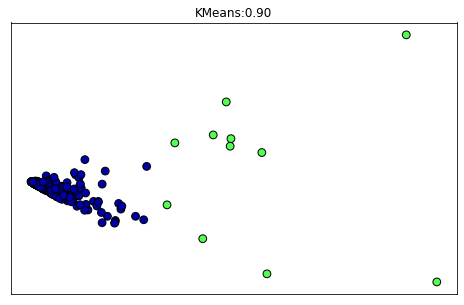

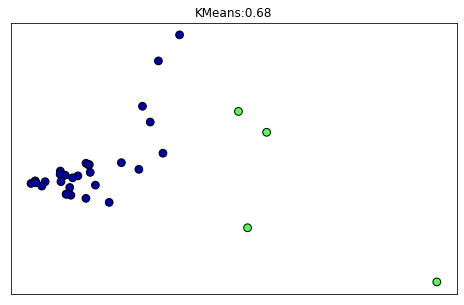

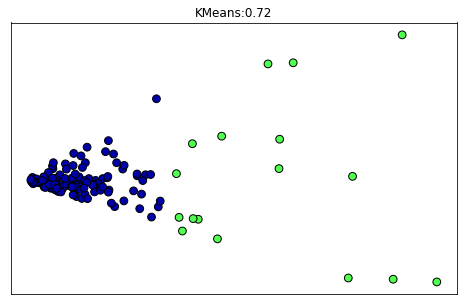

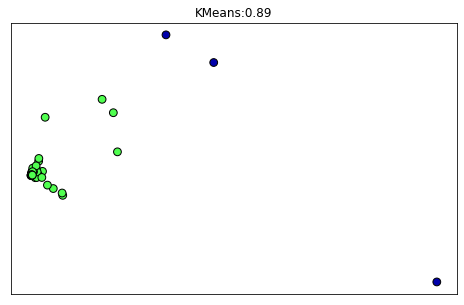

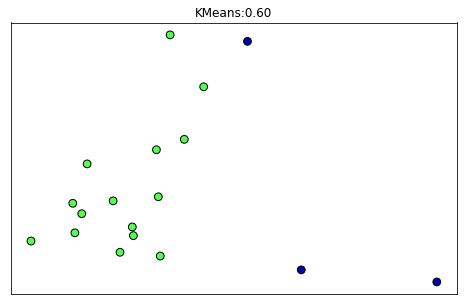

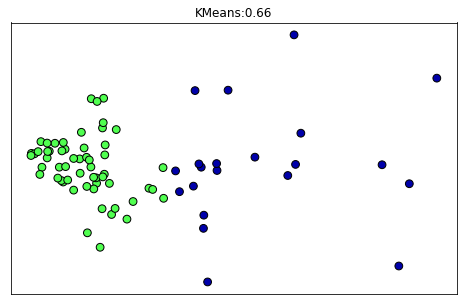

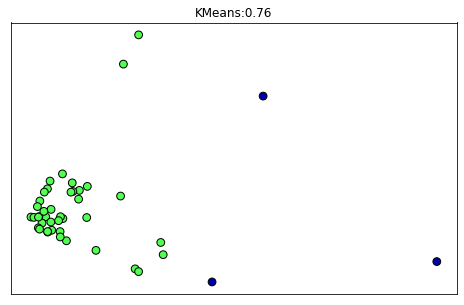

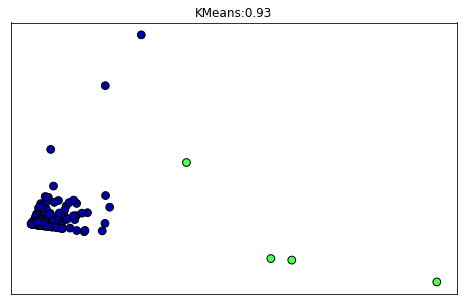

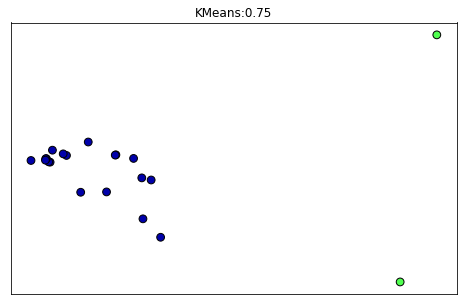

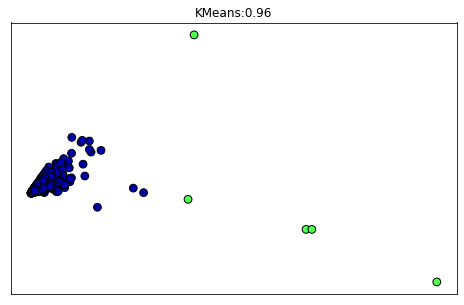

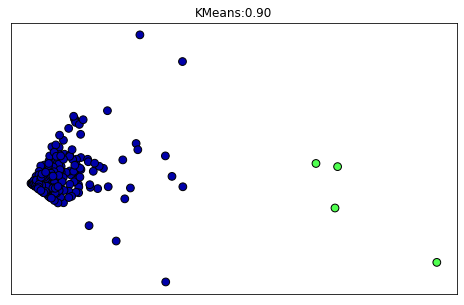

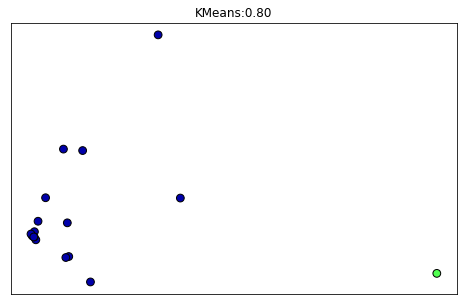

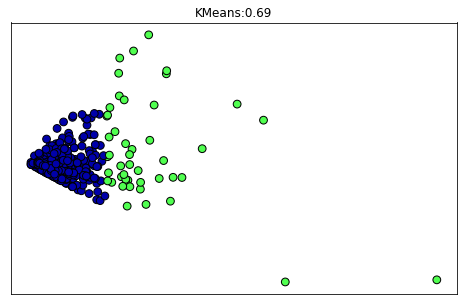

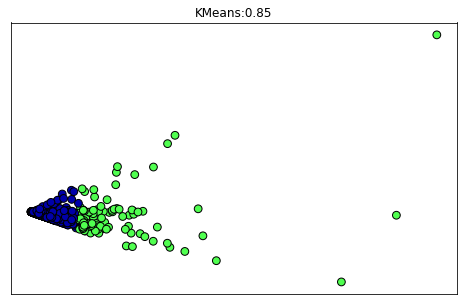

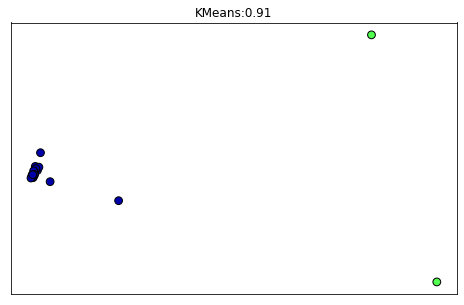

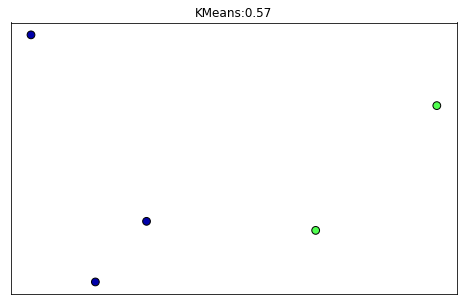

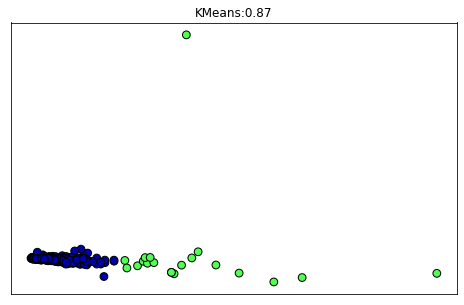

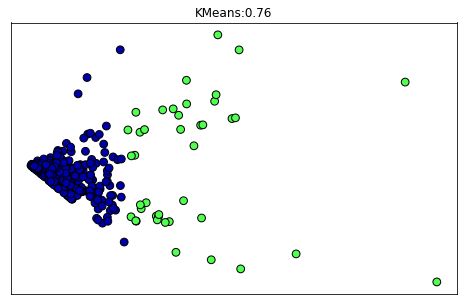

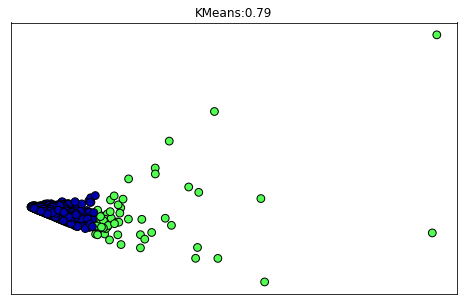

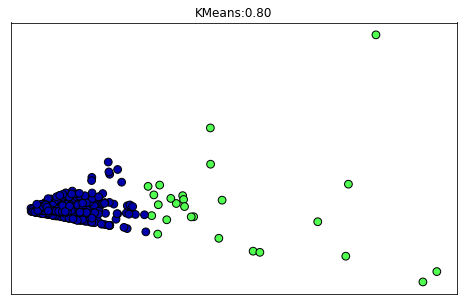

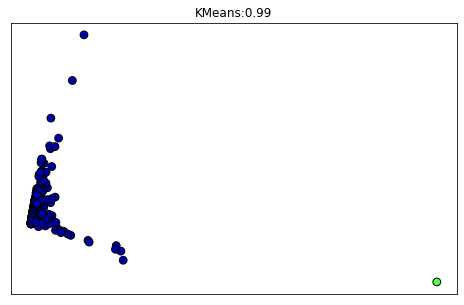

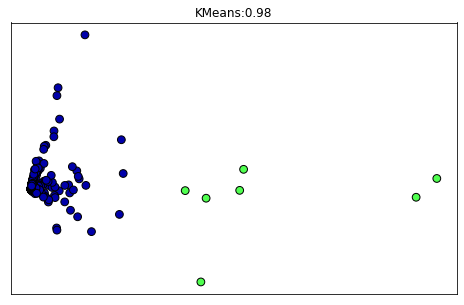

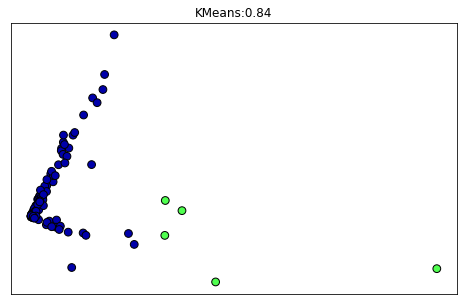

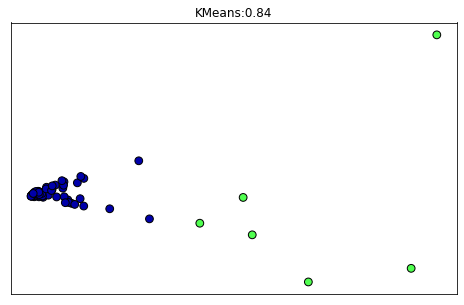

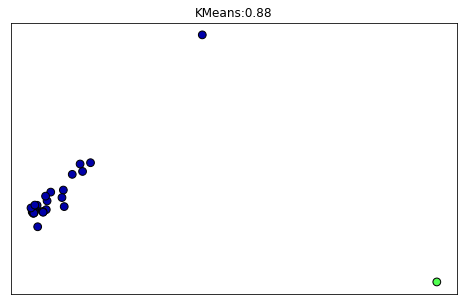

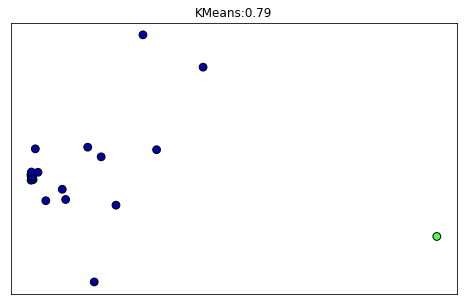

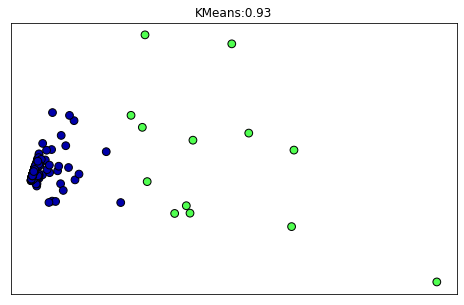

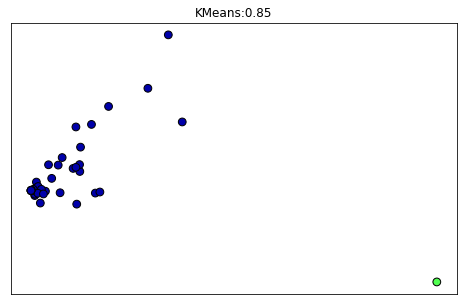

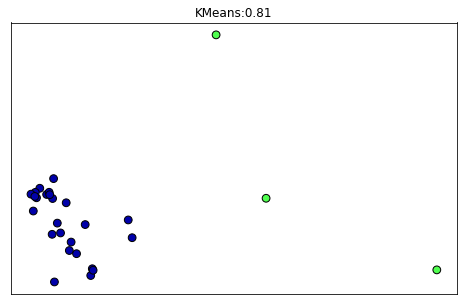

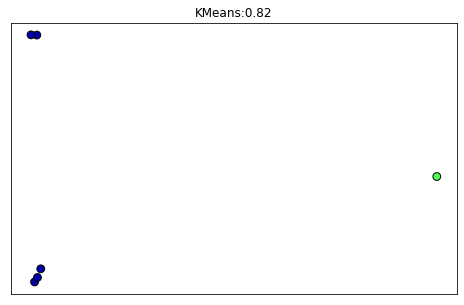

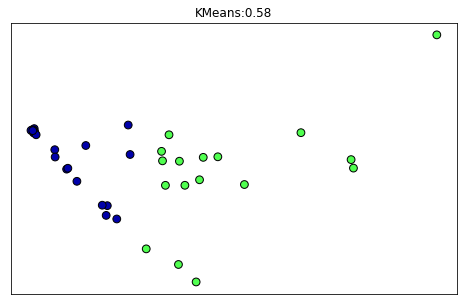

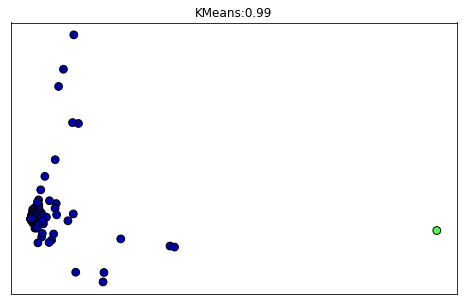

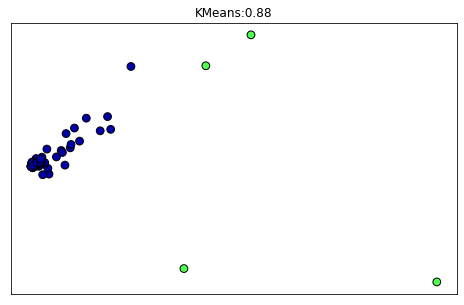

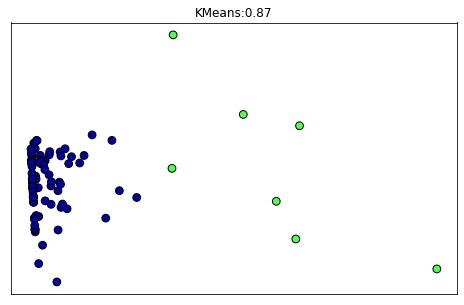

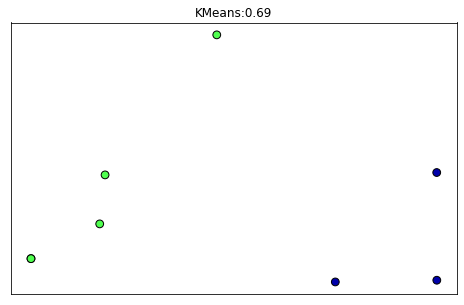

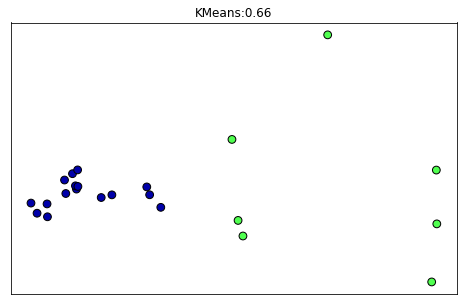

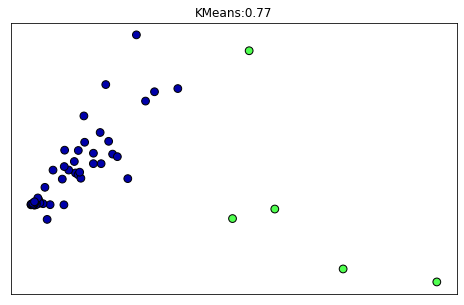

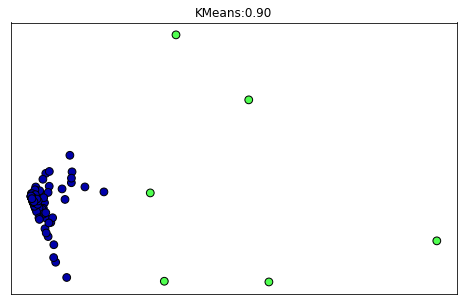

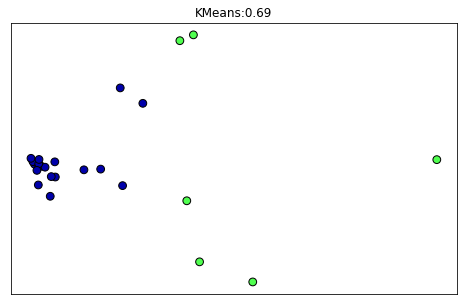

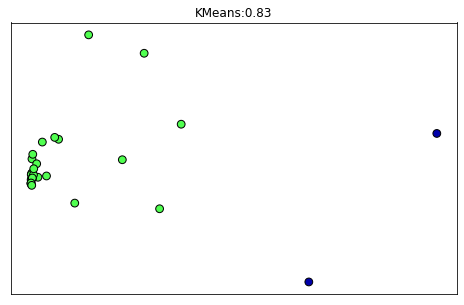

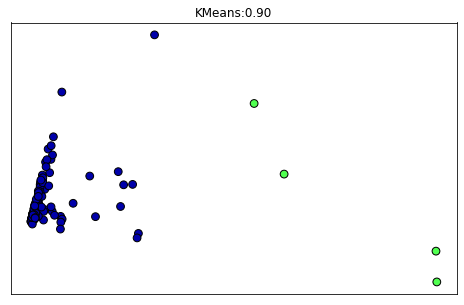

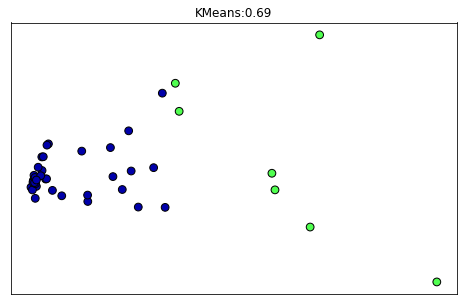

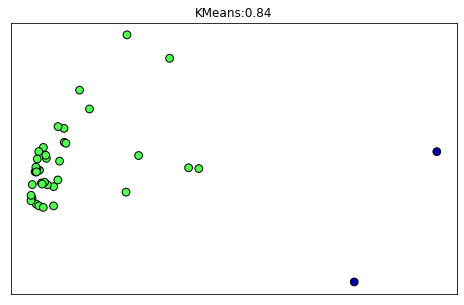

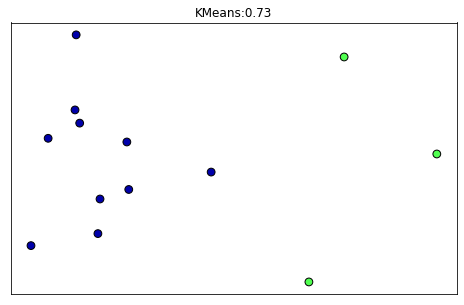

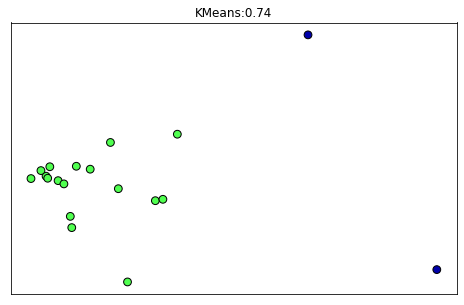

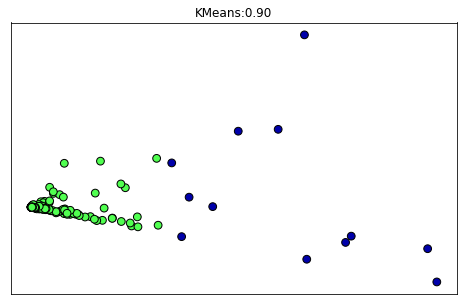

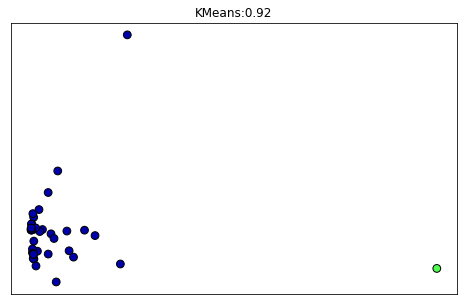

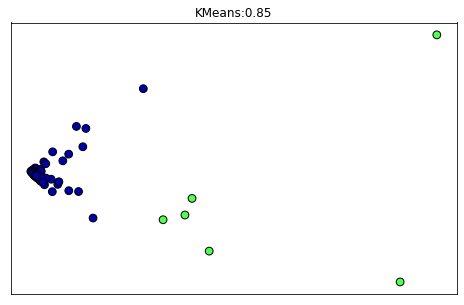

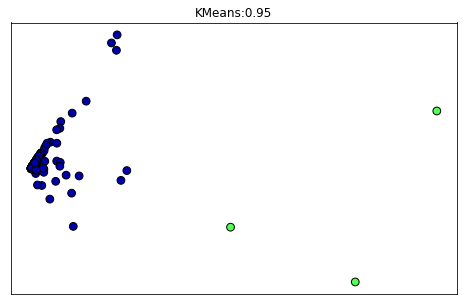

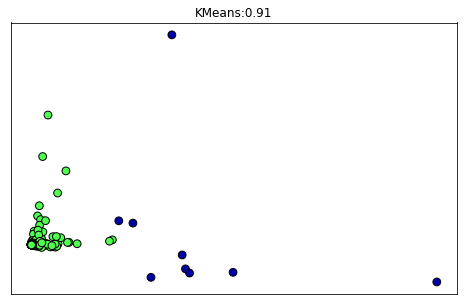

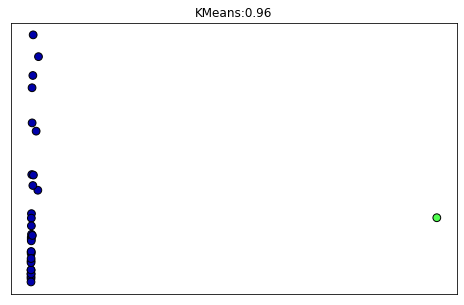

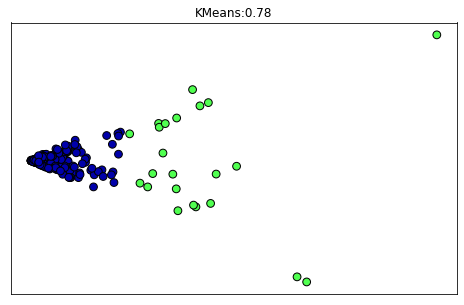

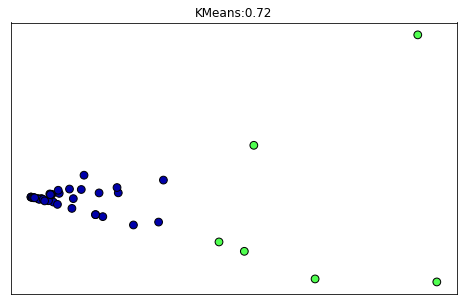

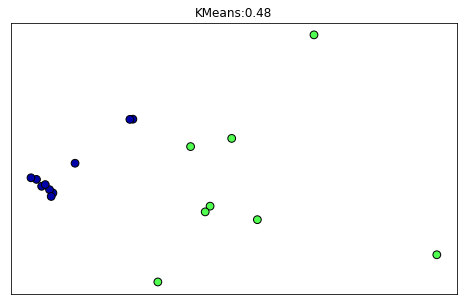

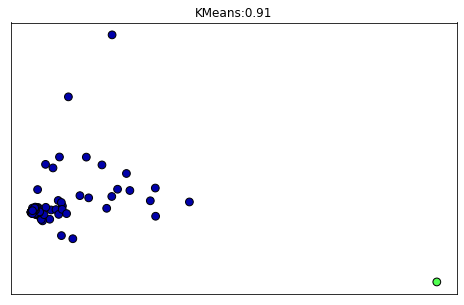

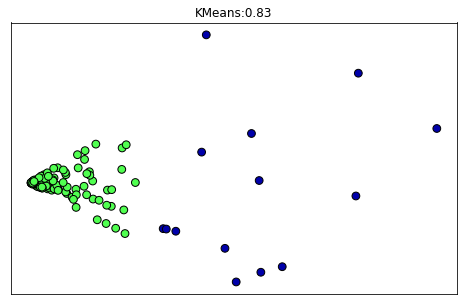

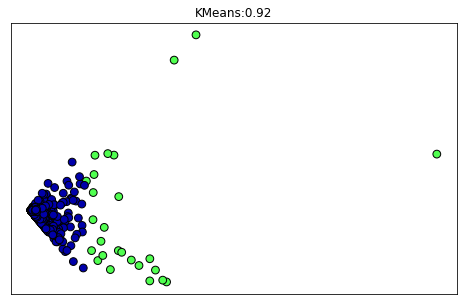

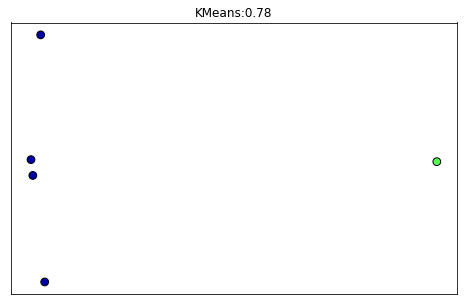

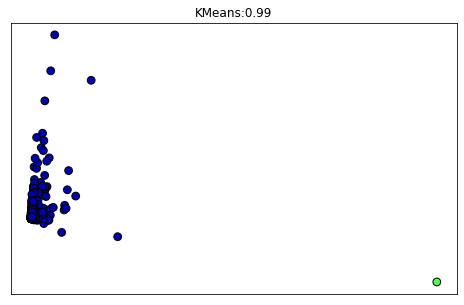

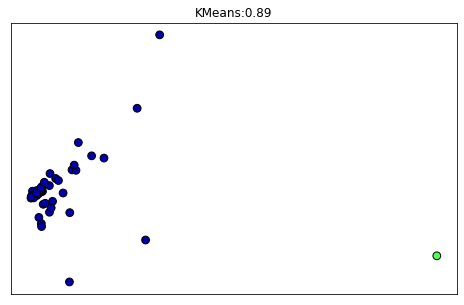

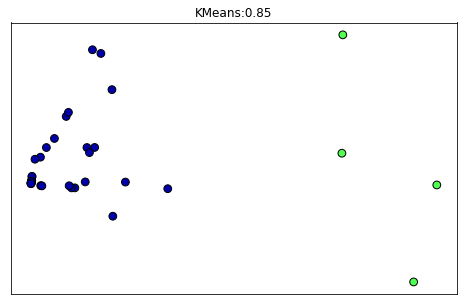

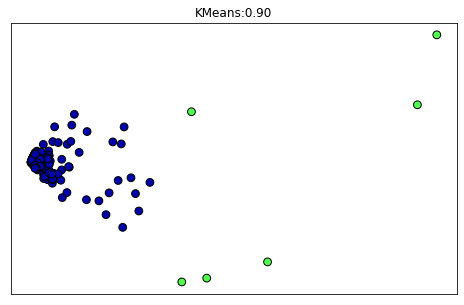

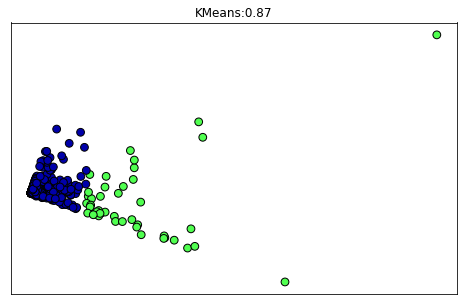

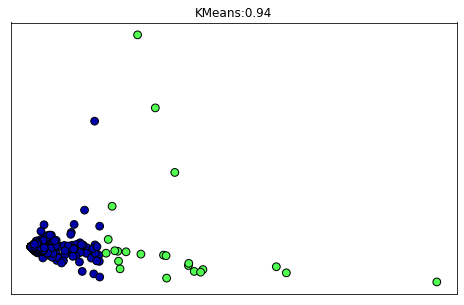

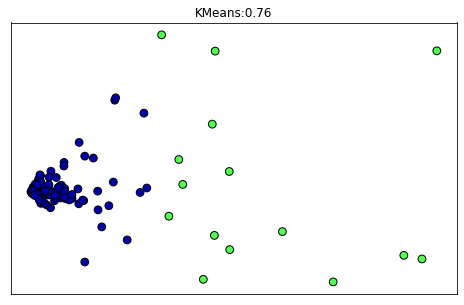

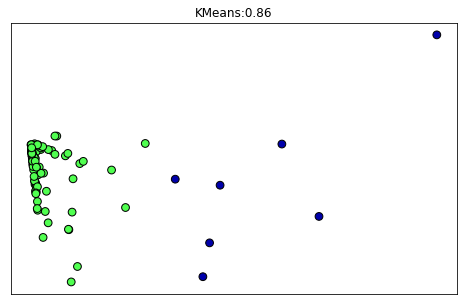

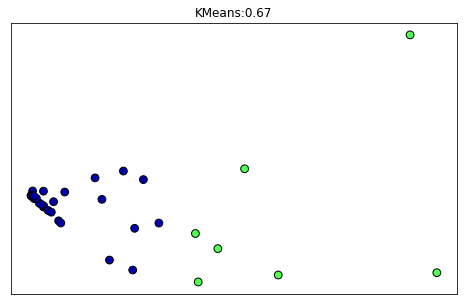

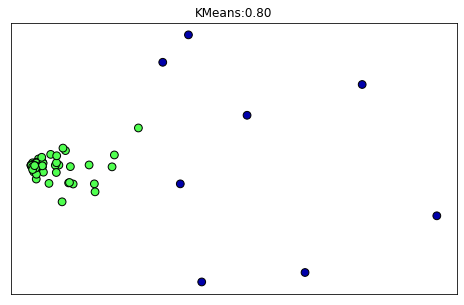

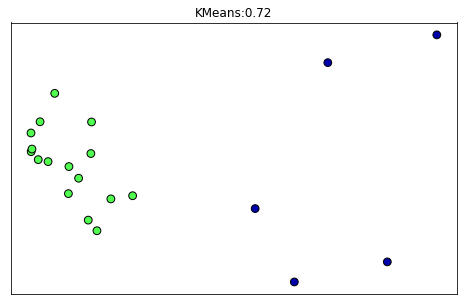

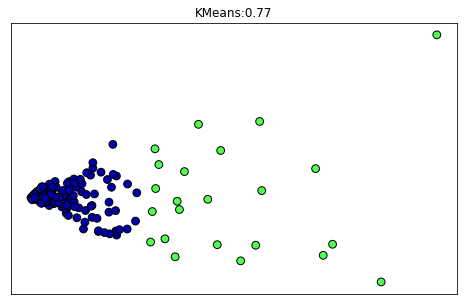

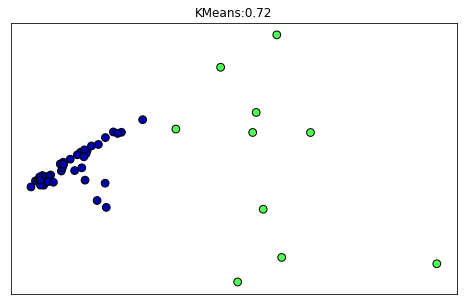

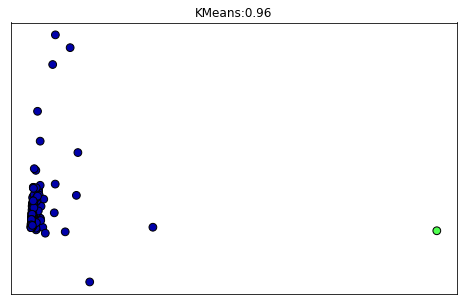

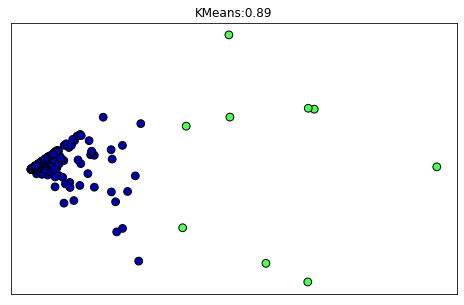

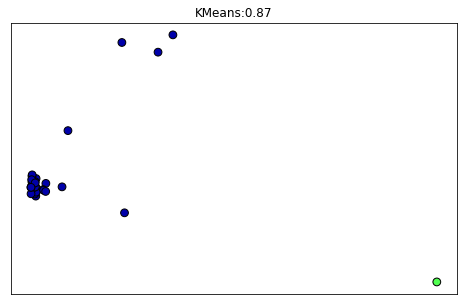

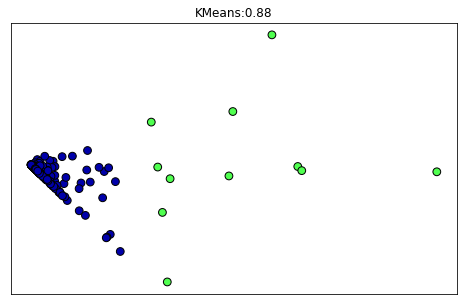

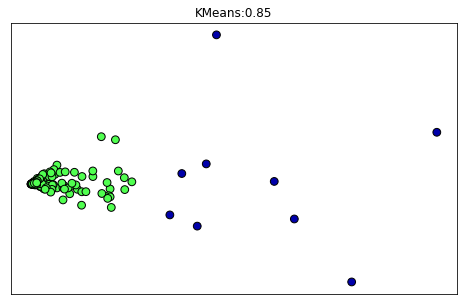

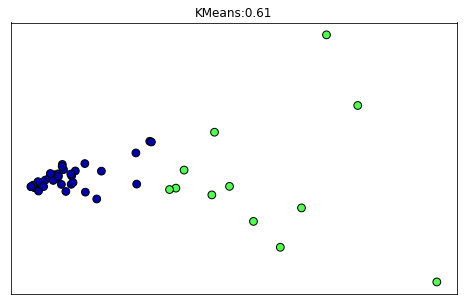

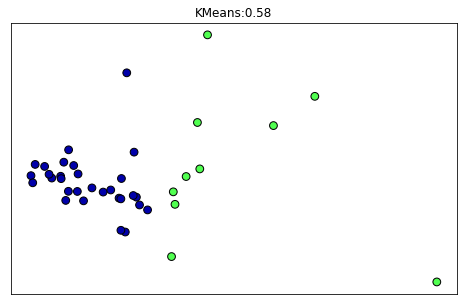

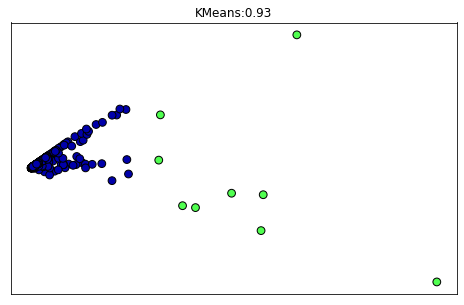

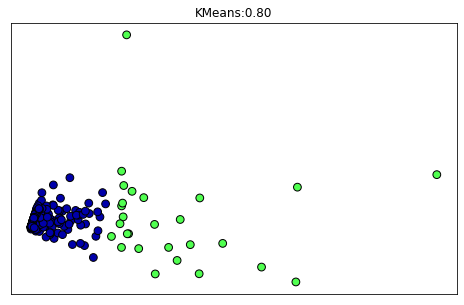

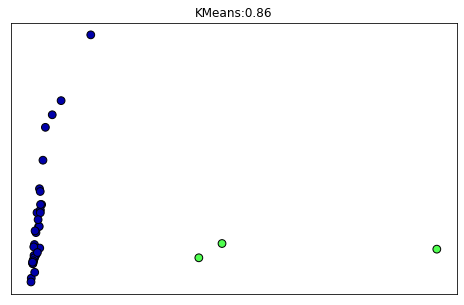

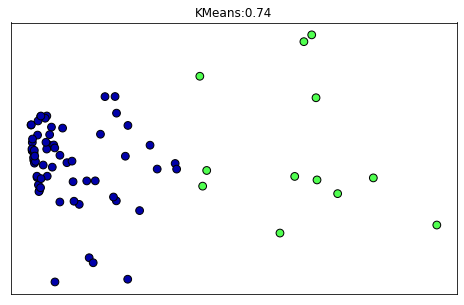

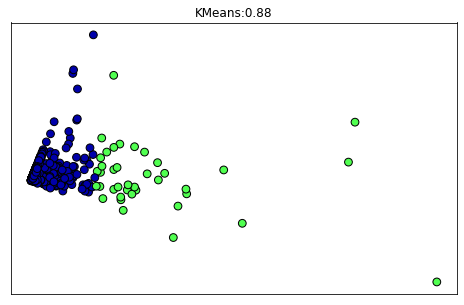

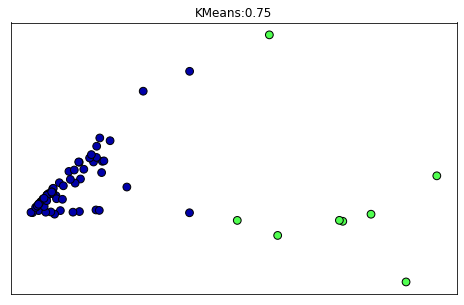

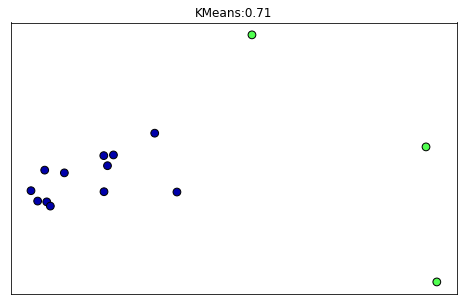

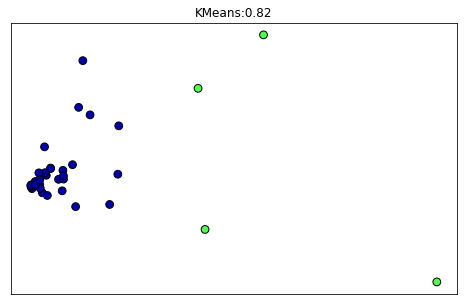

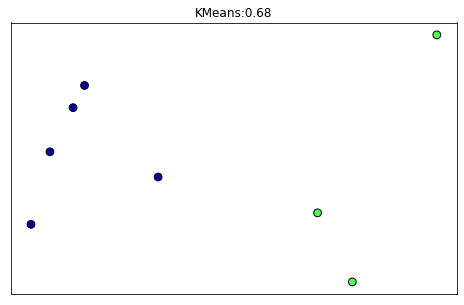

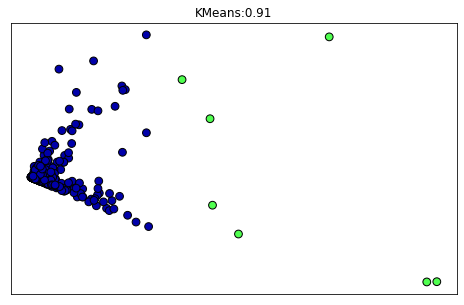

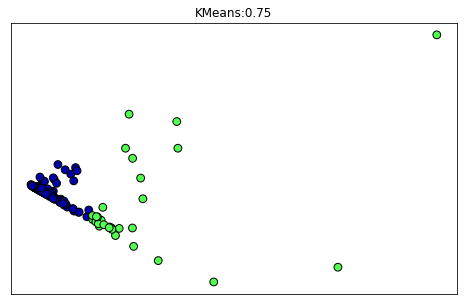

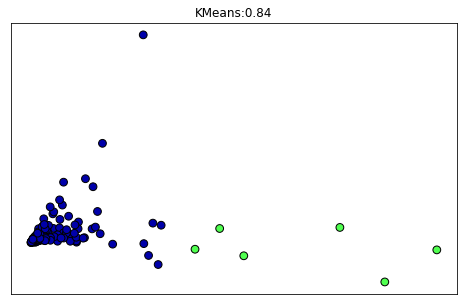

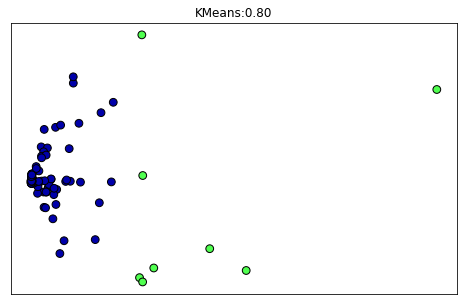

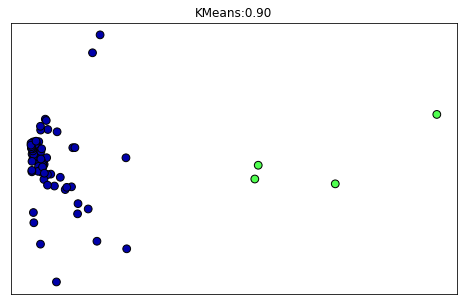

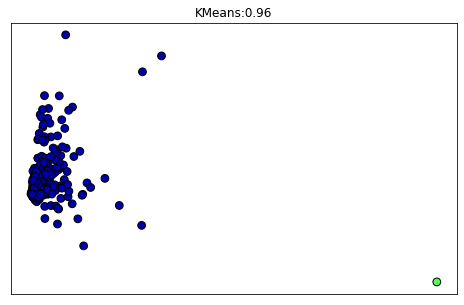

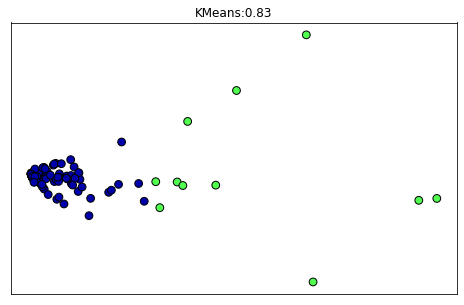

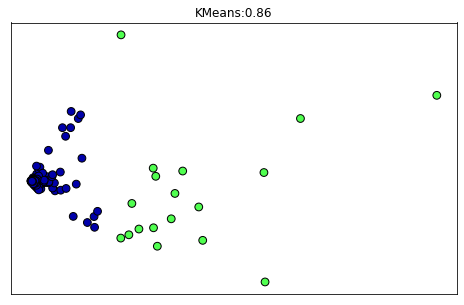

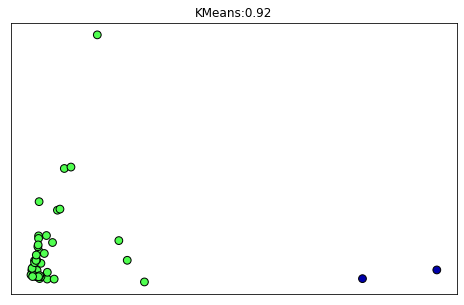

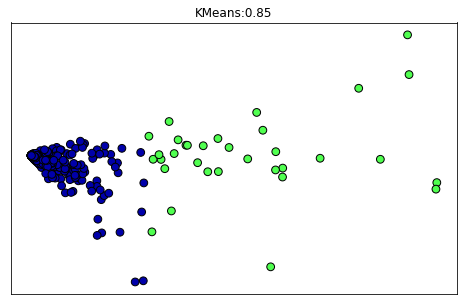

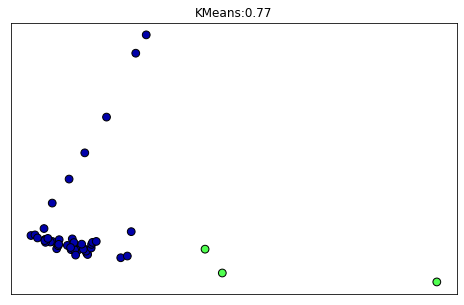

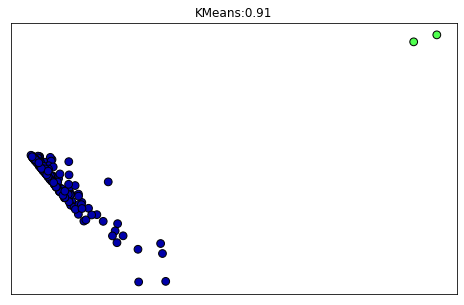

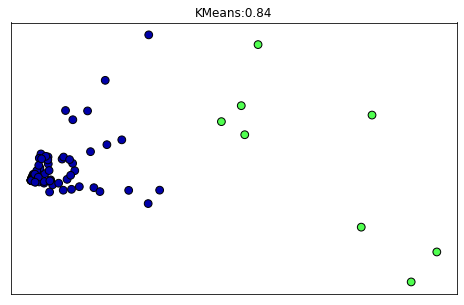

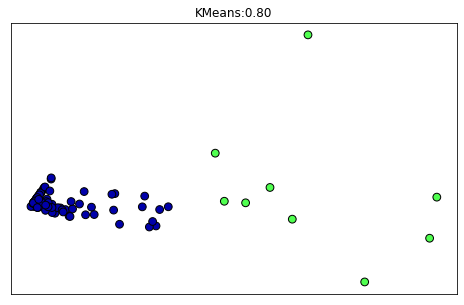

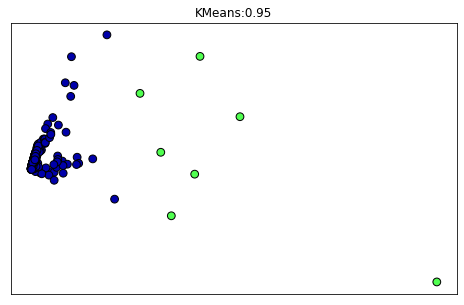

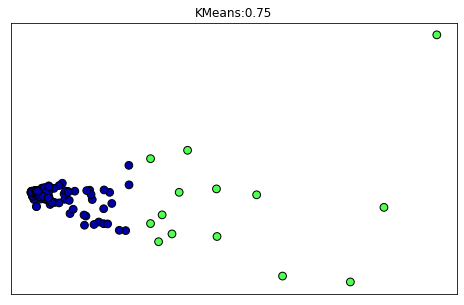

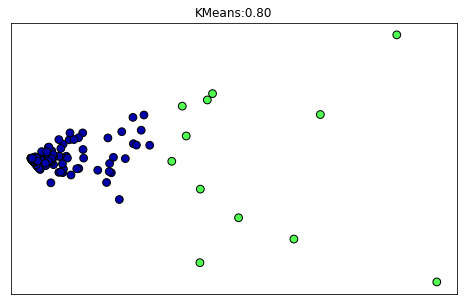

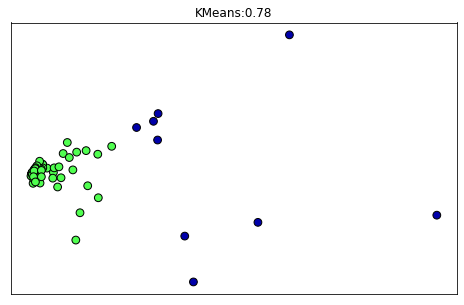

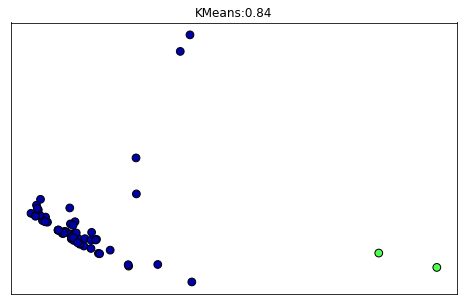

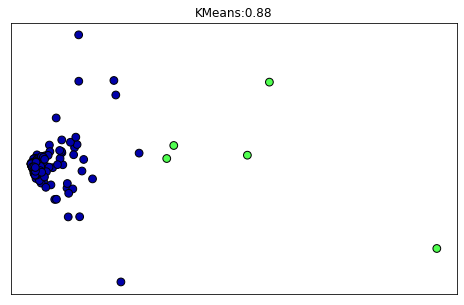

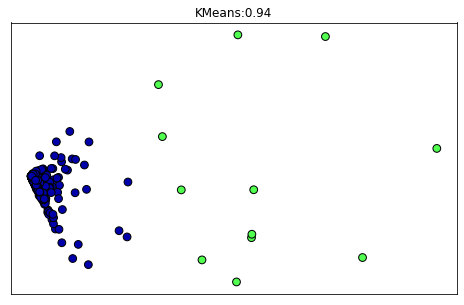

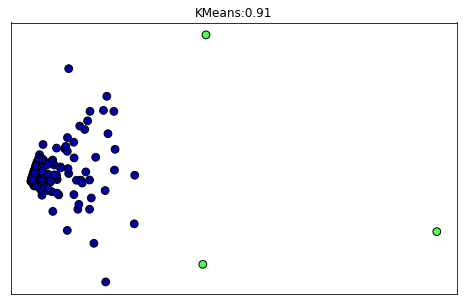

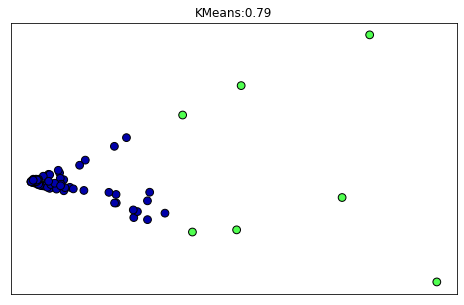

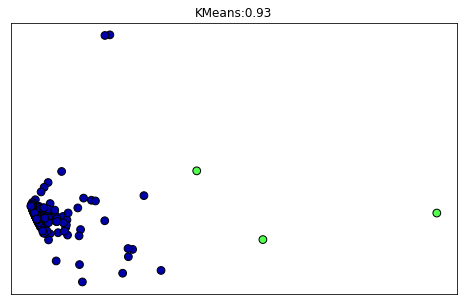

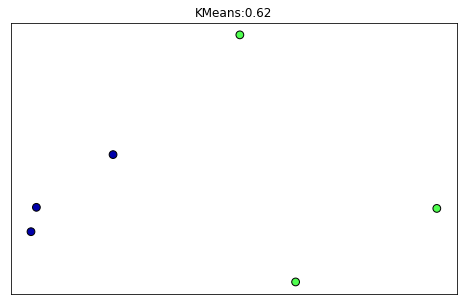

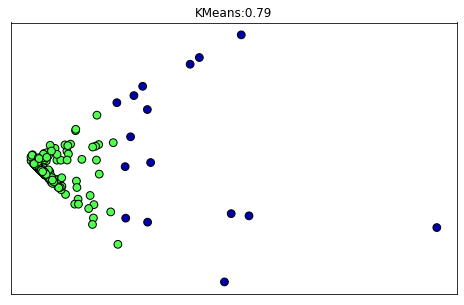

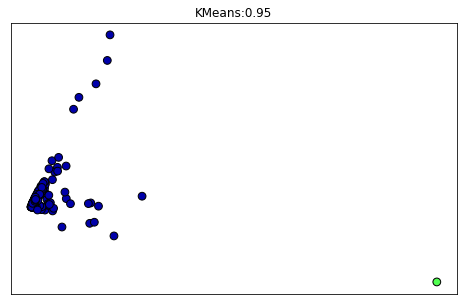

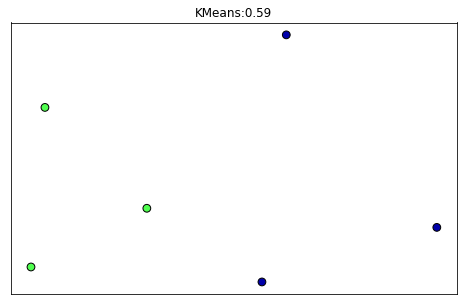

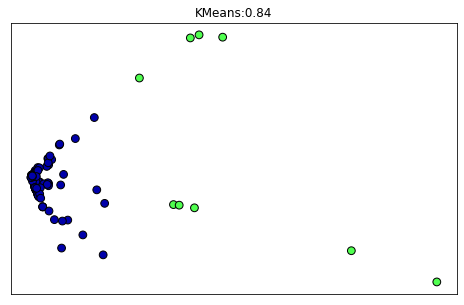

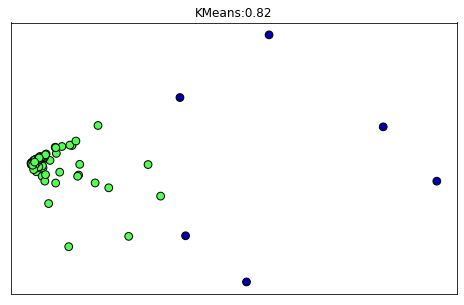

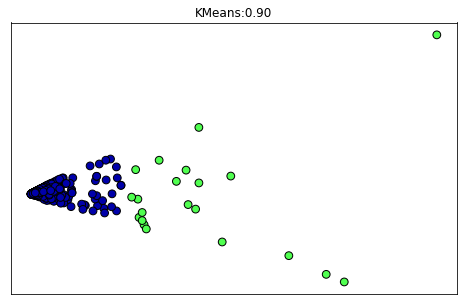

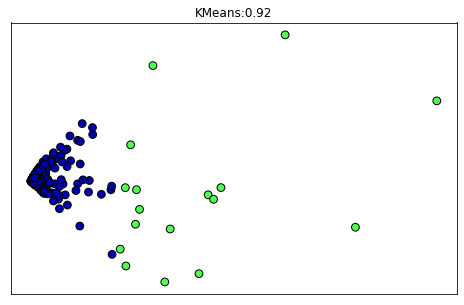

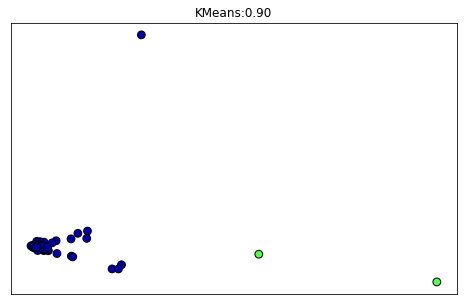

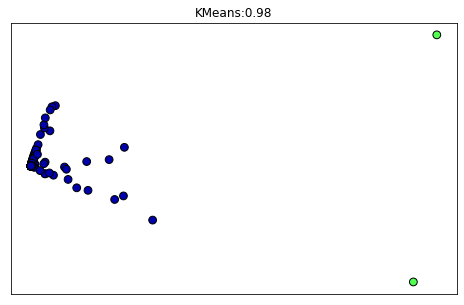

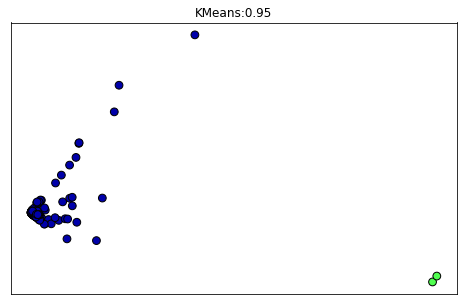

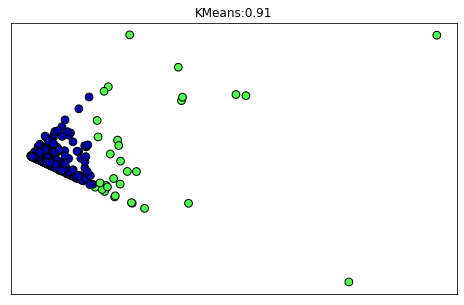

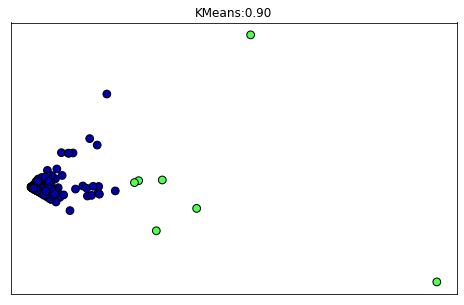

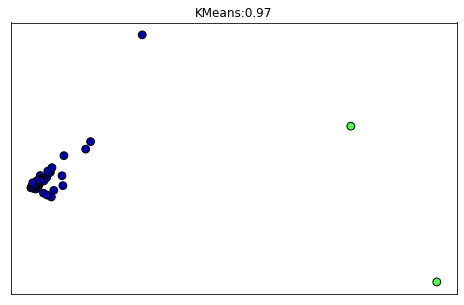

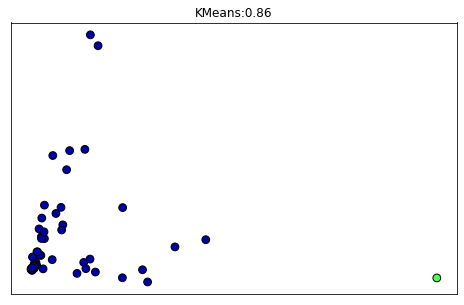

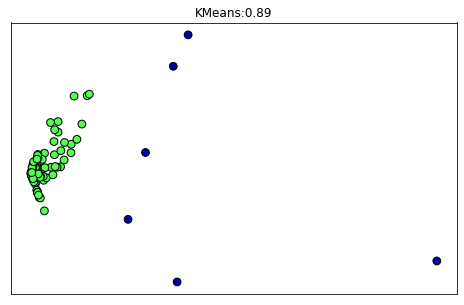

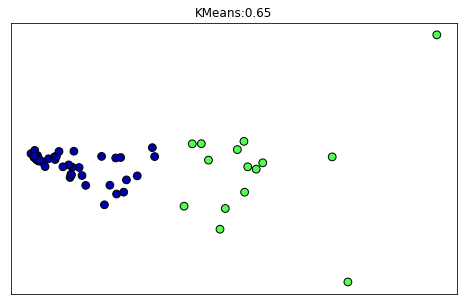

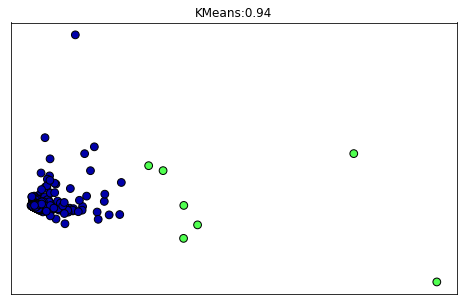

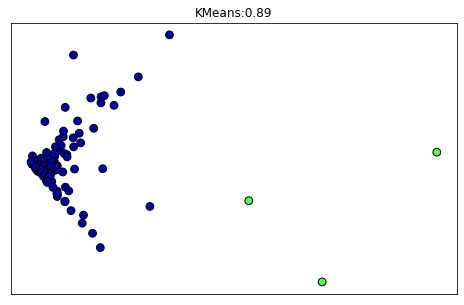

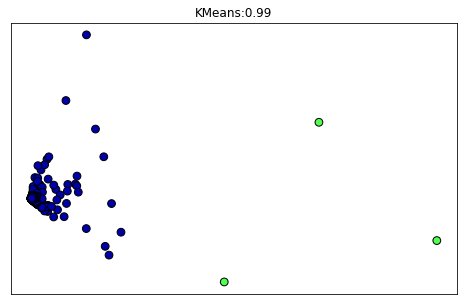

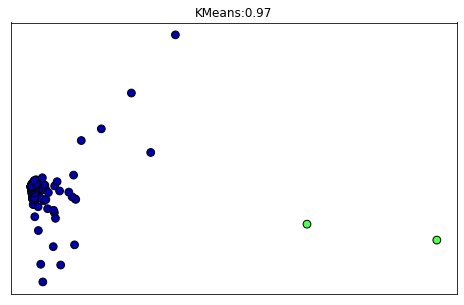

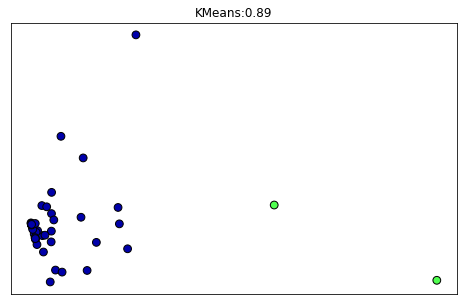

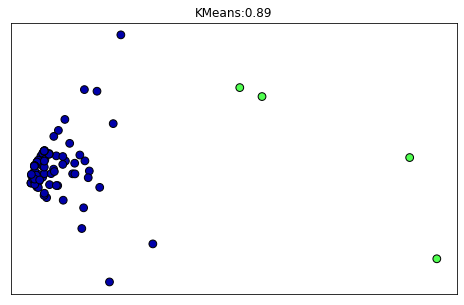

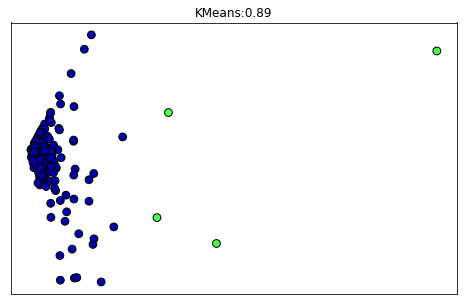

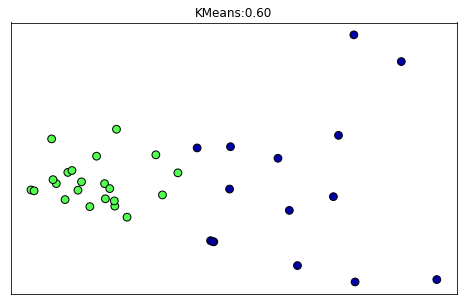

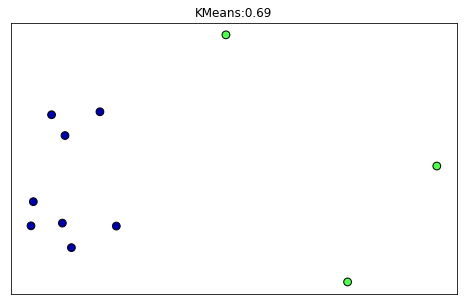

In [14]:
# functions에 넣어야함 
# ML_세분류
dfs = [] 
for i in range(0, 193): 
 df_c = df_process_food_scaling_kmeans[df_process_food_scaling_kmeans['STD_CTG_ID_ML']==i]   

 if (df_c.shape[0] > 2):    # 최소 성분이 2개 이상인 경우만 
  pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정 
  printcipalComponents = pca.fit_transform(df_c.values)
  principalDf          = pd.DataFrame(data=printcipalComponents, columns=['p1','p2']) 

  # 1개 짜리 그래프   
  fig, axes = plt.subplots(1, 1, figsize=(8, 5), subplot_kw={'xticks':(), 'yticks':()})
  X_scaled = principalDf.values

  random_state = np.random.RandomState(seed=0)
  random_clusters = random_state.randint(low=0, high=2, size=len(X_scaled))

  # 무작위 할당 클러스터 그림
  algorithms = [KMeans(n_clusters=2)]   # KMeans
  for algorithm in algorithms: 
    ax = axes
    clusters = algorithm.fit_predict(X_scaled)
    df_c = df_c.reset_index() # 아래 clusters의 index와 맞춰서 merge 하기 위함 ( 기존 인덱스 정보는 남겨놓음 다시 join 해야함 )
    df_c = pd.merge(df_c, pd.DataFrame(clusters), left_index=True, right_index=True)    
    dfs.append(df_c)    
    ax.scatter(X_scaled[:,0], X_scaled[:,1], c=clusters, cmap=mglearn.cm3, s=60, edgecolors='black')
    ax.set_title("{}:{:.2f}".format(algorithm.__class__.__name__, silhouette_score(X_scaled, clusters)))       

## 클러스터에 해당 하는 item_id 매칭작업

In [15]:
# dfs[0]
df_process_food_reset_index = df_process_food.reset_index()
df = dfs[0]
df = df.rename(columns={0:'CLUSTER'})
# df[df['CLUSTER'] == 1]

# df_dfs_n_item_id = df_order_pr['ITEM_ID'].iloc[dfs[0]['index']]
c0_index = df[df['CLUSTER'] == 0]['index']
c1_index = df[df['CLUSTER'] == 1]['index']

df_dfs_n_item_id_c0 = pd.DataFrame(df_process_food_reset_index['ITEM_ID'].iloc[c0_index])
df_dfs_n_item_id_c1 = pd.DataFrame(df_process_food_reset_index['ITEM_ID'].iloc[c1_index])
df_dfs_n_item_id_c0

,ITEM_ID
0,105
1,2338
2,2412
3,2419
4,3098
...,...
481,1978542
484,1980885
485,1987055
490,1999170


## 1-2. 실적 데이터 - 학습
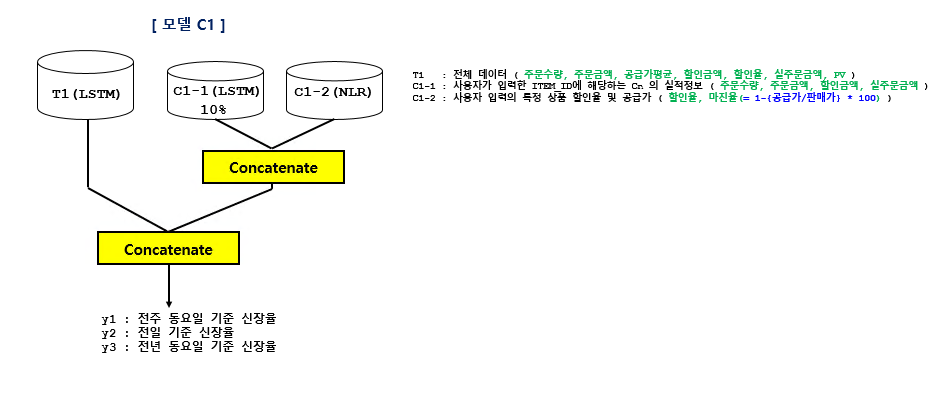

### 모델링

In [16]:
# model 1 ( total data 관련 lstm )
model1 = models.model_create_timeseries_for_concatenate(7, 2) # 7일단위 ( memory cell ) 5개 feature 데이터를 저장 

# model 2 
model2 = models.model_create_timeseries_for_concatenate(7, 4) # 7일단위 (memory cell) 4개 feature ( PV가 없음 )데이터 저장

# model 3 
model3 = models.create_nonlinear_model(1)

### 설계도

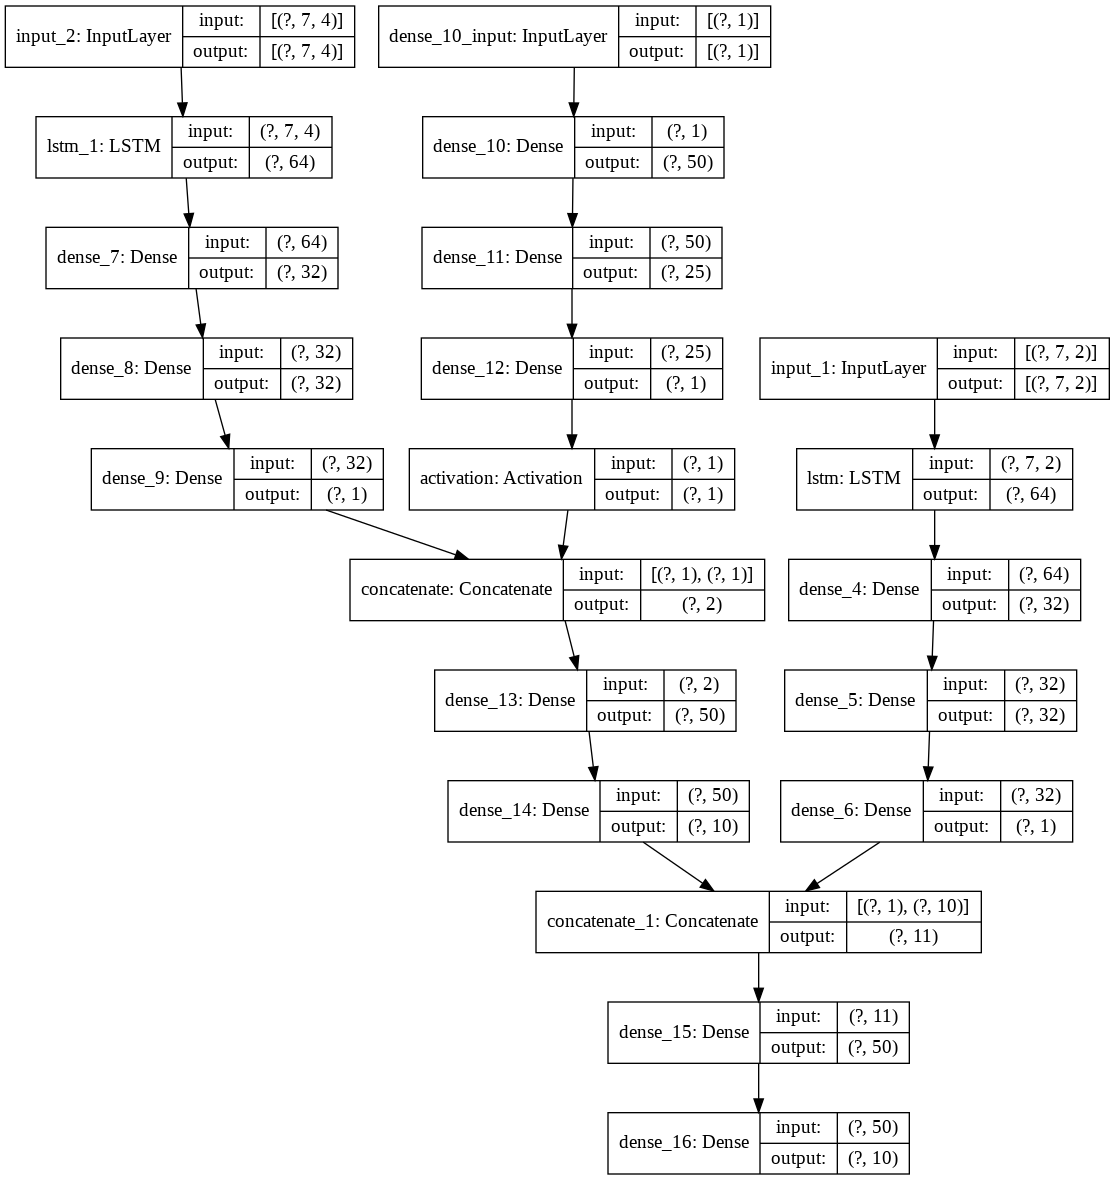

In [17]:
from keras.utils import plot_model
combinedInput = concatenate([model2.output, model3.output])
x = Dense(50, activation="relu")(combinedInput)
x = Dense(10, activation="relu")(x)
model_merged = Model(inputs=[model2.input, model3.input], outputs=x) # lstm + nonlinear

# model model2(lstm) + model3(nonlinear)
combinedInput = concatenate([model1.output, model_merged.output])
x = Dense(50, activation="relu")(combinedInput)
x = Dense(10, activation="relu")(x)
model_merged_final = Model(inputs=[model1.input, model_merged.input], outputs=x)
plot_model(model_merged_final, to_file='model_merged_final.png', show_shapes=True)

### 전체데이터

In [18]:
# 1년치 pv 데이터 ( pv값이 07-20 ~ 09-09까지 없어서 해당 일자는 임의로 값 넣음 )
df_pv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019(pv).csv')
df_pv = df_pv.rename(columns={'to_char':'REG_DT','pv':'PV'})

# 1년치 주문 데이터 ( 상품군 상관없이 전체)
df_01_12_total = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_01_to_06(total).csv') 
df_01_12_total = df_01_12_total.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_07_to_12(total).csv'))
df_01_12_total = df_01_12_total.reset_index()
df_01_12_total = df_01_12_total.drop(['index'], axis=1)
df_01_12_total = df_01_12_total.rename(columns={'orord_dt':'REG_DT'})
df_01_12_total.columns = df_01_12_total.columns.str.upper()


# 1년치 할인율 데이터 ( 상품군 상관없이 전체)
df_dc_rate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_01(dc_rate).csv')
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_02(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_03(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_04(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_05(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_06(dc_rate).csv'))
df_dc_rate = df_dc_rate.rename(columns={'avg_day_dc_rate':'day_dc_rate'})
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_07(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_08(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_09(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_10(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_11(dc_rate).csv'))
df_dc_rate = df_dc_rate.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/2019_12(dc_rate).csv'))

df_dc_rate = df_dc_rate.reset_index()
df_dc_rate = df_dc_rate.drop(['index'], axis=1)
df_dc_rate = df_dc_rate.rename(columns={'orord_dt':'REG_DT','day_dc_rate':'DAY_DC_RATE'})

# date 포맷으로 통일 
df_01_12_total['REG_DT'] = pd.to_datetime(df_01_12_total['REG_DT'], format='%Y-%m-%d')
df_dc_rate['REG_DT'] = pd.to_datetime(df_dc_rate['REG_DT'], format='%Y-%m-%d')
df_pv['REG_DT'] = pd.to_datetime(df_pv['REG_DT'],format='%Y%m%d')

# dataframe join 
df_pv = df_pv.set_index('REG_DT')
df_dc_rate = df_dc_rate.set_index('REG_DT')
df_01_12_total = df_01_12_total.set_index('REG_DT')

df_01_12_total = pd.merge(df_01_12_total, df_pv, left_index=True, right_index=True, how='left')
df_01_12_total = pd.merge(df_01_12_total, df_dc_rate, left_index=True, right_index=True, how='left')
df_01_12_total = df_01_12_total.drop(['AVG_DAY_DC_RATE'],axis=1)

# 하루 데이터 없어서 결측치 처리 (임의)
df_01_12_total = df_01_12_total.fillna(16042457.0)
df_01_12_total

print(df_pv)
print(df_01_12_total)
print(df_dc_rate)

                  PV
REG_DT              
2019-01-01  32396351
2019-01-02  24760443
2019-01-03  21770629
2019-01-04  19033809
2019-01-05  18220601
2019-01-06  19413135
2019-01-07  22505687
2019-01-08  21307827
2019-01-09  19682234
2019-01-10  19449213
2019-01-11  17522008
2019-01-12  16802434
2019-01-13  19359508
2019-01-14  23216378
2019-01-15  21753010
2019-01-16  20547742
2019-01-17  20135058
2019-01-18  18090054
2019-01-19  17783899
2019-01-20  19263233
2019-01-21  22172146
2019-01-22  22261910
2019-01-23  19865919
2019-01-24  20706561
2019-01-25  20382395
2019-01-26  19813057
2019-01-27  20932577
2019-01-28  25306657
2019-01-29  22554461
2019-01-30  21430196
2019-01-31  20890663
2019-02-01  19822746
2019-02-02  17825164
2019-02-03  17019320
2019-02-04  14160812
2019-02-05  14021109
2019-02-06  20322352
2019-02-07  25304070
2019-02-08  24044425
2019-02-09  21344315
2019-02-10  22553678
2019-02-11  25465842
2019-02-12  24717847
2019-02-13  23802915
2019-02-14  23704454
2019-02-15  2

In [19]:
df_01_12_total = df_01_12_total.drop(['SUM_DAY_ORD_CNT','SUM_DAY_DC_AMT','DAY_DC_RATE'],axis=1)

In [20]:
x1, y1 = functions.split_xy5(df_01_12_total.values, 7, 1) # 전체 데이터 split ( 7일 기준으로 다음 1일 예측)

# 데이터 셋 나누기 ( train_test_split 생략함 , 전체데이터 가지고 테스트 )
# Standard Scaling 하기 위해 2차원 배열로 변경
x1_train = np.reshape(x1, (x1.shape[0], x1.shape[1] * x1.shape[2])) 

#### 데이터 전처리 #####
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler1.fit(x1_train)
x1_train_scaled = scaler1.transform(x1_train)
x1_train_scaled = np.reshape(x1_train_scaled, (x1_train_scaled.shape[0], 7, 2)) 

In [21]:
# 클러스터 학습용 데이터 추출 
df_c1_0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Data 저장소/Phase9 RawData/c1_0_ord_item.csv')
df_c1_0.columns = df_c1_0.columns.str.upper()
df_c1_0 = df_c1_0.drop(['ITEM_ID.1'], axis=1)
df_c1_0 = df_c1_0.rename(columns={'ORORD_DT':'REG_DT'})
df_c1_0_model2_3 = df_c1_0
df_c1_0_model2_3['REG_DT'] = pd.to_datetime(df_c1_0_model2_3['REG_DT'], format='%Y-%m-%d')
df_c1_0_model2_3 = df_c1_0_model2_3.drop(['ITEM_ID'], axis=1)
grouped = df_c1_0_model2_3.groupby('REG_DT')
df_c1_0_model2_3 = grouped.mean()

df_c1_0_model2_3_lstm = df_c1_0_model2_3[['DAY_ORD_CNT','DAY_RLORD_QTY','DAY_ORD_AMT','DAY_RLORD_AMT']]
# df_c1_0_model2_3_nonlinear = df_c1_0_model2_3[['DAY_ORD_AMT', 'DAY_DC_AMT', 'DAY_SPLPRC']]  # 공급가 정보 제외
df_c1_0_model2_3_nonlinear = df_c1_0_model2_3[['DAY_ORD_AMT', 'DAY_DC_AMT']]
df_c1_0_model2_3_lstm = df_c1_0_model2_3_lstm.reset_index()
df_c1_0_model2_3_nonlinear = df_c1_0_model2_3_nonlinear.reset_index()
# df_c1_0_model2_3_lstm
df_c1_0_model2_3_nonlinear['DAY_DC_RATE'] = df_c1_0_model2_3_nonlinear['DAY_DC_AMT'] / df_c1_0_model2_3_nonlinear['DAY_ORD_AMT'] * 100
df_c1_0_model2_3_nonlinear

# 2019-01-01 ~ 2019-12-31 
df_c1_0_model2_3_lstm = df_c1_0_model2_3_lstm.loc[(df_c1_0_model2_3_lstm['REG_DT'] >= '2019-01-01') & (df_c1_0_model2_3_lstm['REG_DT'] <= '2019-12-31')]
df_c1_0_model2_3_lstm = df_c1_0_model2_3_lstm.drop(['REG_DT'], axis=1)
df_c1_0_model2_3_lstm = df_c1_0_model2_3_lstm.reset_index()
df_c1_0_model2_3_lstm = df_c1_0_model2_3_lstm.drop(['index'], axis=1)
# df_c1_0_model2_3_lstm

df_c1_0_model2_3_nonlinear = df_c1_0_model2_3_nonlinear.reset_index()
df_c1_0_model2_3_nonlinear = df_c1_0_model2_3_nonlinear.drop(['index'], axis=1)
df_c1_0_model2_3_nonlinear = df_c1_0_model2_3_nonlinear.loc[(df_c1_0_model2_3_nonlinear['REG_DT']>='2019-01-01')&(df_c1_0_model2_3_nonlinear['REG_DT'] <= '2019-12-31')]
df_c1_0_model2_3_nonlinear
# x3_train = df_c1_0_model2_3_nonlinear
# df_c1_0_model2_3_lstm

,REG_DT,DAY_ORD_AMT,DAY_DC_AMT,DAY_DC_RATE
14,2019-01-01,182485.460298,15029.311414,8.235895
15,2019-01-02,250238.749149,17704.258797,7.074947
16,2019-01-03,240046.025287,17170.283908,7.152913
17,2019-01-04,213521.831981,15528.590962,7.272601
18,2019-01-05,145186.821337,11352.808483,7.819448
19,2019-01-06,167532.349624,12496.276942,7.459023
20,2019-01-07,238192.952915,16555.465247,6.950443
21,2019-01-08,246432.517564,19972.227166,8.104542
22,2019-01-09,209755.672598,14569.129300,6.945762
23,2019-01-10,219819.767303,16813.226730,7.648642


In [22]:
# df_c1_0_model2_3_lstm.loc[22]
df_c1_0

,REG_DT,ITEM_ID,DAY_ORD_CNT,DAY_RLORD_QTY,DAY_SPLPRC,DAY_ORD_AMT,DAY_DC_AMT,DAY_RLORD_AMT
0,2019-01-01,9920,1,2,8500,11000,0,11000
1,2019-01-19,9920,1,3,12750,16500,1320,15180
2,2019-01-29,9920,1,1,4250,5500,385,5115
3,2019-03-01,9920,1,1,4250,5500,0,5500
4,2019-03-10,9920,1,2,8500,11000,0,11000
...,...,...,...,...,...,...,...,...
259345,2020-01-10,8118016,8,8,21443,29280,1342,27938
259346,2020-01-11,8118016,5,5,12410,18300,915,17385
259347,2020-01-12,8118016,5,5,13468,18300,801,17499
259348,2020-01-13,8118016,9,9,22867,32940,1527,31413


In [23]:
# 컬럼순서 변경 ( 종속변수 주문수량에서 주문금액으로 변경)
df_c1_0_model2_3_lstm = df_c1_0_model2_3_lstm[['DAY_RLORD_AMT','DAY_ORD_CNT',	'DAY_RLORD_QTY',	'DAY_ORD_AMT']]

In [24]:
x2, y2 = functions.split_xy5(df_c1_0_model2_3_lstm.values, 7, 1)
x2_train = np.reshape(x2, (x2.shape[0], x2.shape[1] * x2.shape[2])) 

#### 데이터 전처리(lstm) #####
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler1.fit(x2_train)

x2_train_scaled = scaler1.transform(x2_train)
x2_train_scaled = np.reshape(x2_train_scaled, (x2_train_scaled.shape[0], 7, 4)) 

#### 데이터 전처리(nonlinear) #####
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
# scale_columns = ['DAY_SPLPRC','DAY_DC_RATE']
scale_columns = ['DAY_DC_RATE']
# print(df_c1_0_model2_3_nonlinear)

# scale_columns = ['DAY_SPLPRC','DAY_ORD_CNT','DAY_DC_AMT','DAY_ORD_AMT','DC_RATE']

# x3_train = df_c1_0_model2_3_nonlinear[['DAY_SPLPRC','DAY_DC_RATE']] # 공급가 정보 주석처리 
x3_train = df_c1_0_model2_3_nonlinear[['DAY_DC_RATE']]
df_c1_0_model2_3_nonlinear[scale_columns] = scaler.fit_transform(df_c1_0_model2_3_nonlinear[scale_columns]) 
x3_train_scaled = df_c1_0_model2_3_nonlinear[['DAY_DC_RATE']]  
# x3_train_scaled = x3_train_scaled[8:366]
y = y2

In [25]:
df_c1_0_model2_3_lstm

,DAY_RLORD_AMT,DAY_ORD_CNT,DAY_RLORD_QTY,DAY_ORD_AMT
0,167456.148883,27.325062,54.858561,182485.460298
1,232534.490352,32.686720,64.986379,250238.749149
2,222875.741379,30.848276,67.777011,240046.025287
3,197993.241020,28.987254,64.590962,213521.831981
4,133834.012853,22.507712,48.080977,145186.821337
5,155036.072682,26.276942,60.794486,167532.349624
6,221637.487668,33.372197,68.765695,238192.952915
7,226460.290398,34.543326,65.850117,246432.517564
8,195186.543298,28.970344,63.972716,209755.672598
9,203006.540573,29.305489,64.243437,219819.767303


In [26]:
x3_train_scaled

,DAY_DC_RATE
14,0.619771
15,0.045277
16,0.083859
17,0.143086
18,0.413693
19,0.235337
20,-0.016334
21,0.554771
22,-0.018650
23,0.329169


In [27]:
# concatenate model 학습
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.1)
model_merged_final.compile(loss="mae", optimizer=opt)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=100)

hist = model_merged_final.fit(	
  [x1_train_scaled, x2_train_scaled, x3_train_scaled[0:358]], [y2], 
  validation_split=0.2, epochs=1000, batch_size=5000, callbacks=[early_stopping])

Epoch 1/1000
1/1 [==============================] - 1s 733ms/step - loss: 209550.5156 - val_loss: 261579.8281
Epoch 2/1000
1/1 [==============================] - 0s 23ms/step - loss: 209523.2500 - val_loss: 260839.2812
Epoch 3/1000
1/1 [==============================] - 0s 24ms/step - loss: 208193.9219 - val_loss: 253153.8594
Epoch 4/1000
1/1 [==============================] - 0s 29ms/step - loss: 199365.7969 - val_loss: 201714.3125
Epoch 5/1000
1/1 [==============================] - 0s 28ms/step - loss: 155229.5625 - val_loss: 57182.6445
Epoch 6/1000
1/1 [==============================] - 0s 24ms/step - loss: 45504.2500 - val_loss: 60081.0977
Epoch 7/1000
1/1 [==============================] - 0s 23ms/step - loss: 106209.2656 - val_loss: 155087.9375
Epoch 8/1000
1/1 [==============================] - 0s 24ms/step - loss: 89686.4766 - val_loss: 177526.6406
Epoch 9/1000
1/1 [==============================] - 0s 21ms/step - loss: 113786.9609 - val_loss: 159296.3438
Epoch 10/1000
1/1 [===

## 특정일자 가공식품(대카:1000027768) 가공식품 주문수량 예측하기
### 주문수량 예측방식 
#### 기존 1년치 ( 정확히 357일치 ) 데이터 기준으로 특정 가공식품(ITEM_ID)의 할인율, 공급가를 지정하고 주문수량 예측 

In [31]:
# 포맷 만들기 (아래 url 참고함)
# https://colab.research.google.com/notebooks/forms.ipynb
import time
#@title Date fields
date_input = '2019-01-25' #@param {type:"date"}
date_input = pd.to_datetime(date_input, format='%Y-%m-%d')
# input      = date_input.ctime()
print(input)
t = time.strptime(str(date_input),'%Y-%m-%d %H:%M:%S')
days = t.tm_yday # 입력일자가 1년(2019)중 몇번째 날인지 취득  

item_id = '9920' #@param {type:"string"}

dc_rate =  32.4#@param {type:"number"} # 할인율

# splprc =  18000#@param {type:"number"} # 공급가

<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7f35991f2390>>


In [32]:
# 해당되는 ITEM_ID 정보 받아옴
df_process_food[df_process_food.index==int(item_id)]

# 어느 클러스터 모델인지 확인

,DAY_ORD_CNT,DAY_RLORD_QTY,DAY_SPLPRC,DAY_ORD_AMT,DAY_DC_AMT,DAY_RLORD_AMT,STD_CTG_ID
ITEM_ID,,,,,,,
9920,1.0,1.833333,7791.666667,10083.333333,430.833333,9652.5,1000028017


In [33]:
# x1_train[21:22]
# x2_train[21:22]
# x3_train[days-1:days]['DAY_SPLPRC'][days-1]  = splprc
x3_train[days-1:days]['DAY_DC_RATE'][days-1] = dc_rate
# x3_train[days-1:days]['DAY_DC_RATE'] = dc_rate
# x3_train[days-1:days]['DAY_SPLPRC'][days-1]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
print(x3_train.values[days-1:days].astype(int))
print(x1_train[days-1:days].astype(int))
print(x2_train[days-1:days].astype(int))

[[6]]
[[ 8349957906    20382395  5895809212    19813057  6934444032    20932577
  12450264744    25306657  9849568337    22554461  7971550403    21430196
   6982293049    20890663]]
[[184887     23     49 197562 129781     19     47 140086 143934     20
      51 153829 258228     29     67 277028 215036     26     61 232637
  184354     24     56 198072 161895     25     57 172472]]


In [35]:
# 전체 평가
np.set_printoptions(threshold=np.inf, linewidth=np.inf) #inf = infinity
print(x1_train_scaled.shape)
print(x2_train.shape)
print(x3_train[0:358].shape)
# loss = model_merged_final.evaluate([x1_train, x2_train, x3_train[0:358].values], [y2], batch_size=5000)
# print('loss : ', loss)
y2_pred = model_merged_final.predict([x1_train_scaled, x2_train_scaled, x3_train_scaled[0:358]])
print('<<<<<<<<<<merged model 예측>>>>>>>>>>')
print('실제 :')
print(y2)
print('예측 : ')
print(y2_pred)

(358, 7, 2)
(358, 28)
(358, 1)
<<<<<<<<<<merged model 예측>>>>>>>>>>
실제 :
[[226460.29039813]
 [195186.54329775]
 [203006.54057279]
 [190819.97037037]
 [128973.49933599]
 [151721.08690176]
 [240975.30022321]
 [214456.57749713]
 [191199.58285052]
 [183810.05350773]
 [171350.53405018]
 [123256.31984334]
 [139969.07808564]
 [210899.31955307]
 [223428.58324022]
 [178192.38843931]
 [196989.69248292]
 [184887.25764706]
 [129781.87239583]
 [143934.32800983]
 [258228.50330396]
 [215036.92081448]
 [184354.74880952]
 [161895.80681818]
 [187543.74379085]
 [128612.06543385]
 [103050.03017241]
 [ 59177.70664506]
 [ 67657.63511188]
 [131074.0078534 ]
 [253674.06153846]
 [226937.04668305]
 [128285.65456989]
 [157140.14322251]
 [237639.08333333]
 [219217.54201183]
 [211408.82238443]
 [194131.80096502]
 [184241.4330413 ]
 [133157.67482014]
 [148960.70445344]
 [214940.21027479]
 [221162.13575758]
 [208307.34418023]
 [191685.51556663]
 [190336.54113111]
 [122400.20319303]
 [141164.71487603]
 [220052.7075588

In [ ]:
# 단건 평가 최종 
x1_train = np.reshape(x1_train, (x1_train.shape[0], 7, 5)) 
x2_train = np.reshape(x2_train, (x1_train.shape[0], 7, 4)) 

print(x1_train.shape)
print(x1_train[days-1:days].shape)
print(x1_train[days-1:days].astype(int))
print(x2_train.shape)
print(x2_train[days-1:days].shape)
print(x2_train[days-1:days].astype(int))
print(x3_train.shape)
print(x3_train[days-1:days].shape)

print(y2[days-8:days-7])

# y값은 lstm 결과값이기 때문에 (8부터 시작, 따라서 특정일자를 예측하려면 y값은 days-7번째 값 필요 )
# loss = model_merged_final.evaluate([x1_train[days-1:days], x2_train[days-1:days], x3_train.values[days-1:days]], [y2[15:16]], batch_size=50)
loss = model_merged_final.evaluate([x1_train[days-1:days], x2_train[days-1:days], x3_train.values[days-1:days]], [y2[days-8:days-7]], batch_size=5000)
print('loss : ', loss)
y2_pred = model_merged_final.predict([x1_train[days-1:days], x2_train[days-1:days], x3_train.values[days-1:days]])
print('<<<<<<<<<<merged model 예측>>>>>>>>>>')
print('실제 :' , y2[days-8:days-7])
print('예측 : ', y2_pred)

In [ ]:
# 실제로 그런가 (c1-0 클러스터의 2019-01-22 발생한 ITEM_ID들의 평균 실적)
df_c1_0_model2_3_validation = df_c1_0_model2_3
df_c1_0_model2_3_validation = df_c1_0_model2_3_validation.reset_index()
df_c1_0_model2_3_validation = df_c1_0_model2_3_validation[df_c1_0_model2_3_validation['REG_DT']>='2019-01-01']
df_c1_0_model2_3_validation = df_c1_0_model2_3_validation[df_c1_0_model2_3_validation['REG_DT']<='2019-12-31']
df_c1_0_model2_3_validation.loc[df_c1_0_model2_3_validation['REG_DT']=='2019-01-22']

In [ ]:
df_c1_test = df_c1_0.drop(['ITEM_ID'], axis=1)
grouped    = df_c1_test.groupby('REG_DT')
df_c1_test = grouped.mean()
df_c1_test = df_c1_test.reset_index()
df_c1_test = df_c1_test.loc[(df_c1_test['REG_DT'] >= '2019-01-01') & (df_c1_test['REG_DT'] <= '2019-12-31') ]
df_c1_test

APPENDIX 영역 

In [ ]:
# 해당 클러스터 전체 모델 평가
# loss = model_merged_final.evaluate([x1_train_scaled, x2_train_scaled, x3_train_scaled[8:366]], [y2], batch_size=5000)
# print('loss : ', loss)
# y2_pred = model_merged_final.predict([x1_train_scaled, x2_train_scaled, x3_train_scaled[8:366]])
# print('<<<<<<<<<<merged model 예측>>>>>>>>>>')
# for i in range(10):    
#     # print('총 매출금액(실제) : ', y1_train[i])     
#     print('세분류 [4000003903] 주문수량(실제) : ', y2[i])
#     print('총 매출금액(예측) : ', y2_pred[i].astype(int))     
#     print()
# 단건 (ITEM_ID) 평가
# loss = model_merged_final.evaluate([x1_train_scaled[21:22], x2_train_scaled[21:22], x3_train_scaled.values[21:22]], [y2[15:16]], batch_size=50)
# print('loss : ', loss)
# y2_pred = model_merged_final.predict([x1_train_scaled[21:22], x2_train_scaled[21:22], x3_train_scaled.values[21:22]])
# print('<<<<<<<<<<merged model 예측>>>>>>>>>>')
# print('실제 :' , y2[15:16])
# print('예측 : ', y2_pred)     
# print()
# print(x1_train_scaled.shape)
# print(x2_train_scaled.shape)
# print(x3_train_scaled.shape)

# print(x1_train_scaled[21:22].shape)
# print(x2_train_scaled[21:22].shape)
# print(x3_train_scaled.values[21:22].shape)
# print(y2[15:16].shape)

# print(x1_train_scaled[22,:].shape)        # 전체
# print(x2_train_scaled[22].shape)        # c1 (lstm)
# print(x3_train_scaled.values[22:29].shape) # c1 (non-linear)
# print(y2[15:22].shape)